First, load the data,in this notebook we are using the Qitta data from the paper "Machine learning–based feature selection to search stable microbial biomarkers: application to inflammatory bowel disease". 


There are 3 datasets, in this work they will be combined together at species and genus level.

These 3 datasets comes from :
1) 96 sampels: Lloyd-Price J, Arze C, Ananthakrishnan AN, et al. Multi-omics of the gut microbial ecosystem in inflammatory bowel diseases. Nature 2019
2) 836 samples: Flores GE, Caporaso JG, Henley JB, et al. Temporal variability is a personalized feature of the human microbiome. Genome Biol 2014
3) 637 samples: Halfvarson J, Brislawn CJ, Lamendella R, et al. Dynamics of the human gut microbiome in inflammatory bowel disease. Nat Microbiol 2017

In [1]:
import sys
sys.path.append('../../../Code')
import loadData 
import RunML
import FS
import metric



2025-05-08 13:43:03.835774: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-08 13:43:03.840424: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-08 13:43:04.604866: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-08 13:43:04.615889: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746726184.633208 1971643 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746726184.63

In [2]:
import pandas as pd
import numpy as np
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import pickle

In [3]:
total_features_species = pd.read_csv('../data/final_combine/features_species_withname_update.csv',index_col = 0)
total_features_genus = pd.read_csv('../data/final_combine/features_genus_withname_update.csv',index_col = 0)
meta_2= pd.read_csv('../data/final_combine/metadata_update.csv',index_col = 0)

In [4]:
print(total_features_species.shape)
print(total_features_genus.shape)

(1569, 283)
(1569, 220)


In [5]:
#print(total_features_species)

In [6]:
genus_name = total_features_genus.columns
species_name = total_features_species.columns

In [7]:
y_label = meta_2['ibd']# for multi classification task
print(pd.Series(y_label).value_counts())

y = meta_2['ibd'].replace({'CD': 'IBD', 'UC': 'IBD'})# for binary classification task
y.value_counts()


ibd
nonIBD    867
UC        366
CD        336
Name: count, dtype: int64


ibd
nonIBD    867
IBD       702
Name: count, dtype: int64

In [8]:
custom_order = ['nonIBD', 'CD', 'UC']
custom_mapping = {category: i for i, category in enumerate(custom_order)}
target_variable_1 = [custom_mapping[category] for category in y_label]
target_variable_1 = np.array(target_variable_1)

In [9]:
le = LabelEncoder()
target_variable_2= le.fit_transform(y)


In [10]:
print(pd.DataFrame(target_variable_2).value_counts())
y.value_counts()
print(pd.DataFrame(target_variable_1).value_counts())

0
1    867
0    702
Name: count, dtype: int64
0
0    867
2    366
1    336
Name: count, dtype: int64


### 2. Calculating H score for each OTU

In [11]:
taxlabels = ['Species','Genus']
feature_df_list = [total_features_species,total_features_genus]

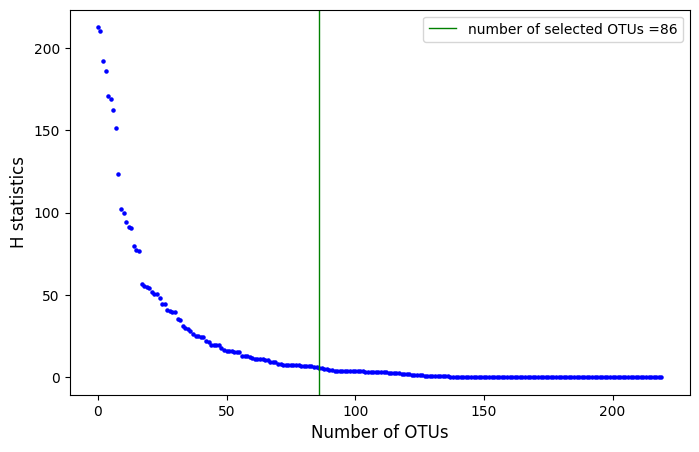

In [12]:
# Multi_Genus

feature_df = feature_df_list[1]

cols_name = feature_df.columns
data = pd.DataFrame(FS.relative_abundance(feature_df),columns = cols_name)

selectedresult_strict_MG = FS.SelectMicro_fun(data,target_variable_1,p_cutoff = 0.05)

X_FS_strict_MG = selectedresult_strict_MG['selected_df']

In [13]:
# feature selection part is done in sbatch
output_data_dir = "../results/combine_multi"

with open(f"{output_data_dir}/Binary_species_data_subset_dict.pkl", "rb") as f:
    loaded_dict_BS = pickle.load(f)

with open(f"{output_data_dir}/Multi_species_data_subset_dict.pkl", "rb") as f:
    loaded_dict_MS = pickle.load(f)

with open(f"{output_data_dir}/Binary_genus_data_subset_dict.pkl", "rb") as f:
    loaded_dict_BG = pickle.load(f)

with open(f"{output_data_dir}/Multi_genus_data_subset_dict.pkl", "rb") as f:
    loaded_dict_MG = pickle.load(f)



/lustre/isaac24/scratch/mhe8/myenv/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


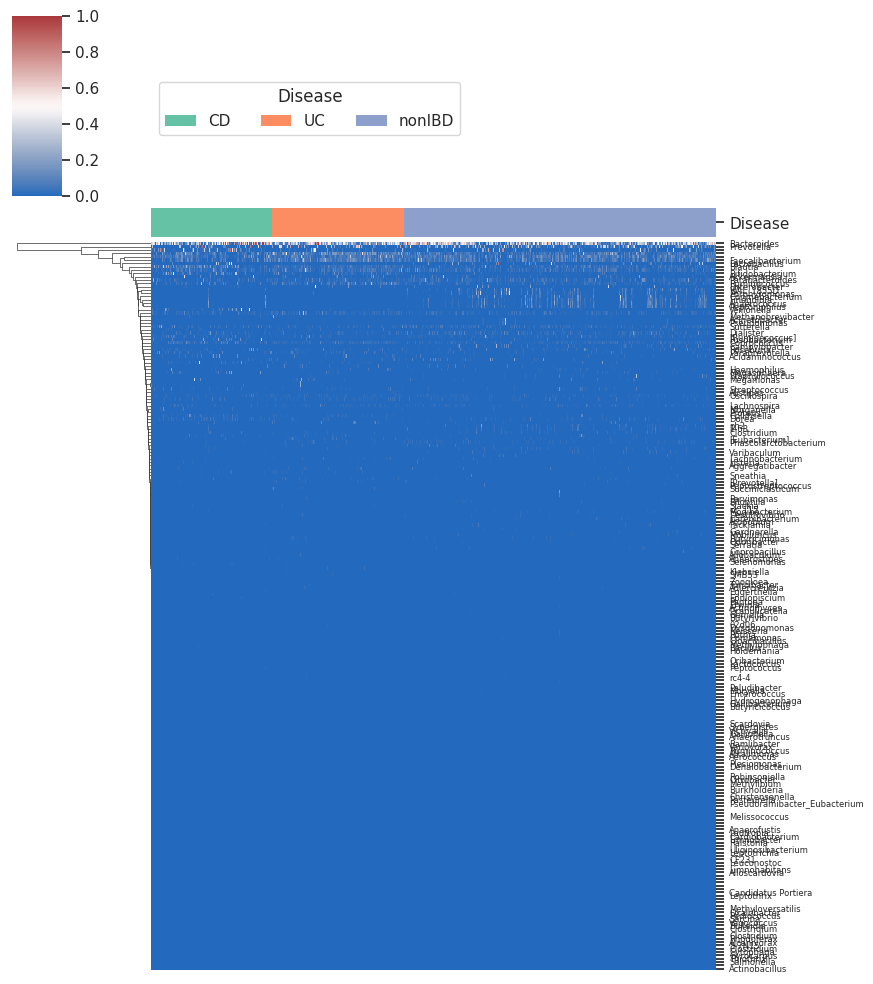

/lustre/isaac24/scratch/mhe8/myenv/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


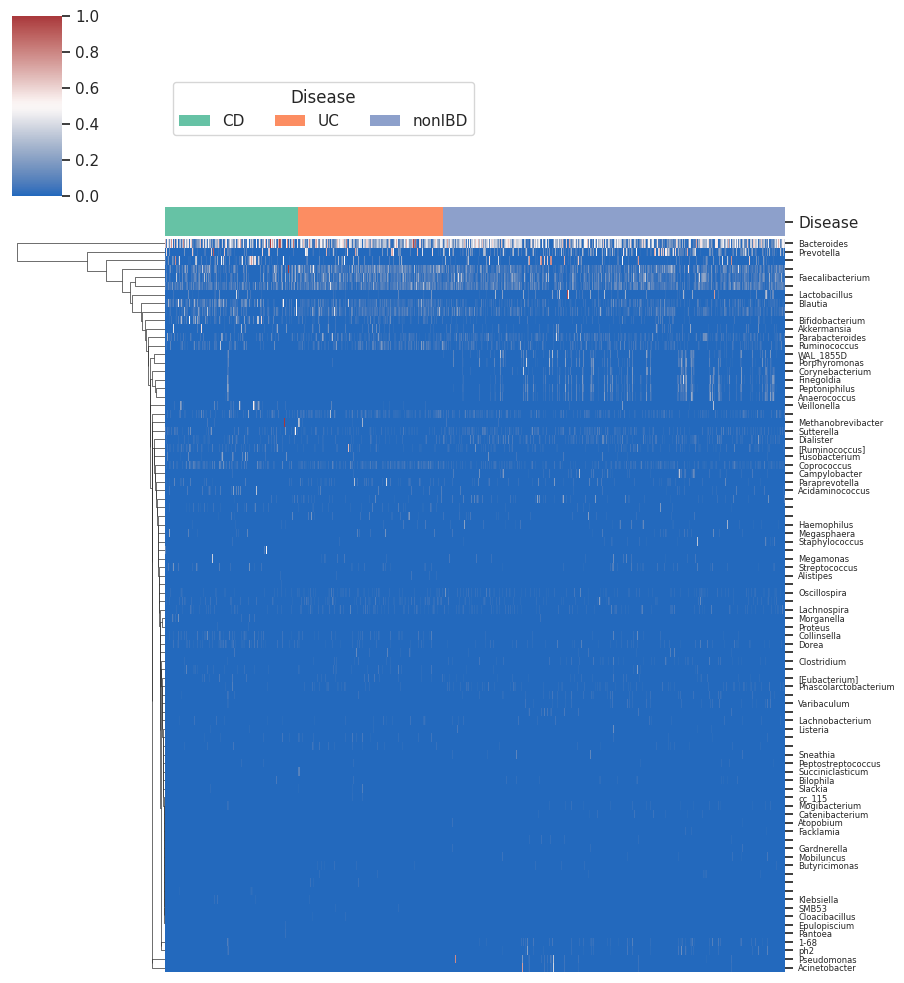

/lustre/isaac24/scratch/mhe8/myenv/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


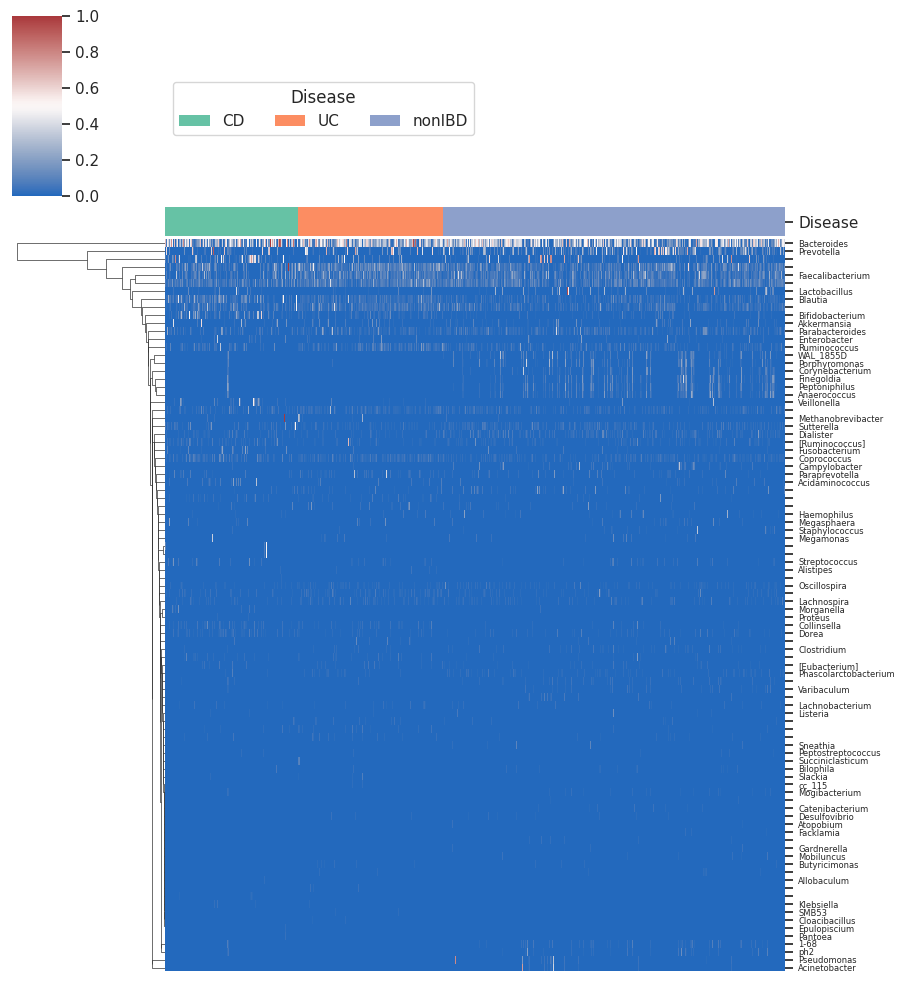

/lustre/isaac24/scratch/mhe8/myenv/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


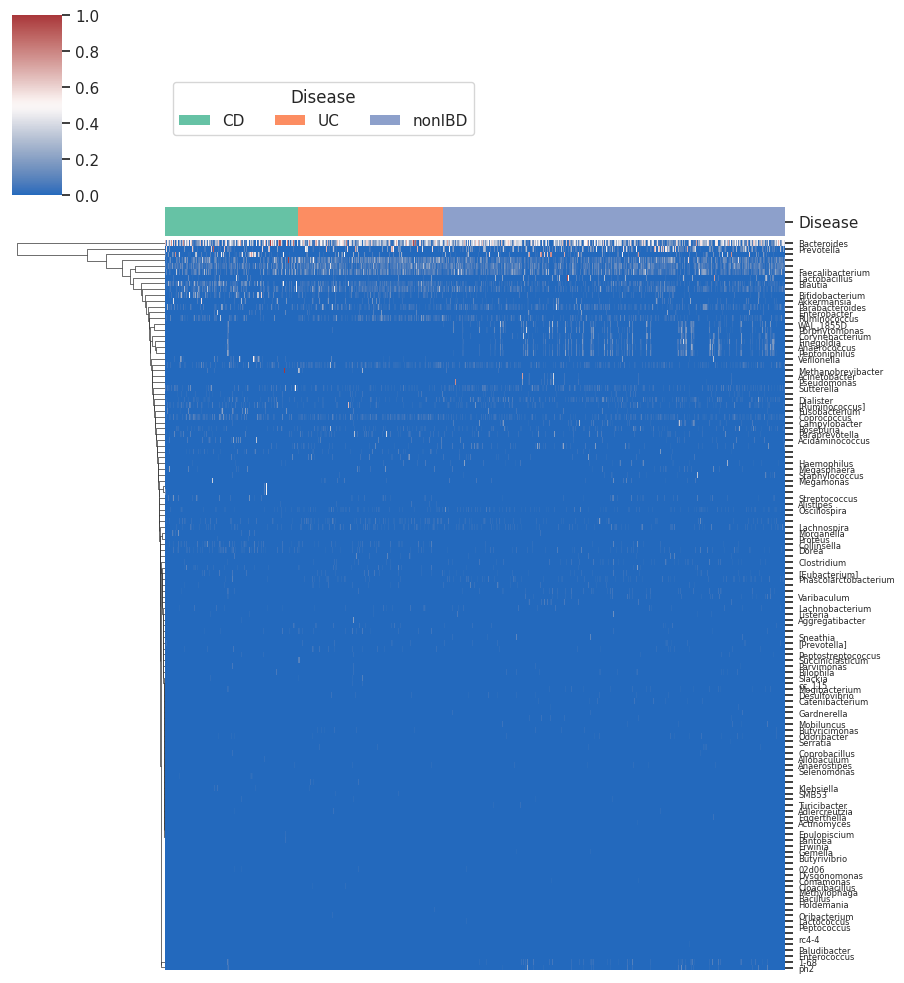

/lustre/isaac24/scratch/mhe8/myenv/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


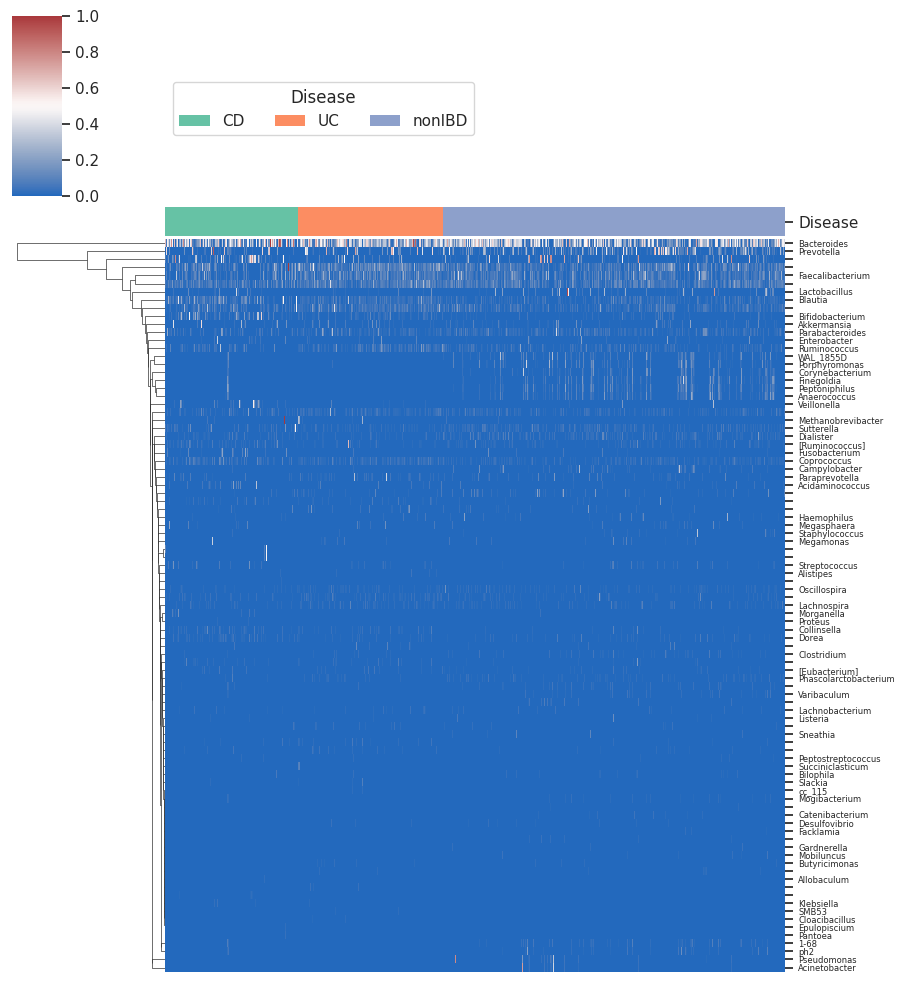

In [14]:


## show the heatmap of binary and multi classification (but y is always annotated with multi)
group_1 = pd.DataFrame({'Disease': y_label})

data_subset = loaded_dict_MG
for datatype, subset in data_subset.items():
    subset.index = meta_2.index
    #metric.plot_heatmap(subset,group_1, column_cluster = True)
    metric.plot_heatmap(subset,group_1, column_cluster = False)     

/lustre/isaac24/scratch/mhe8/myenv/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


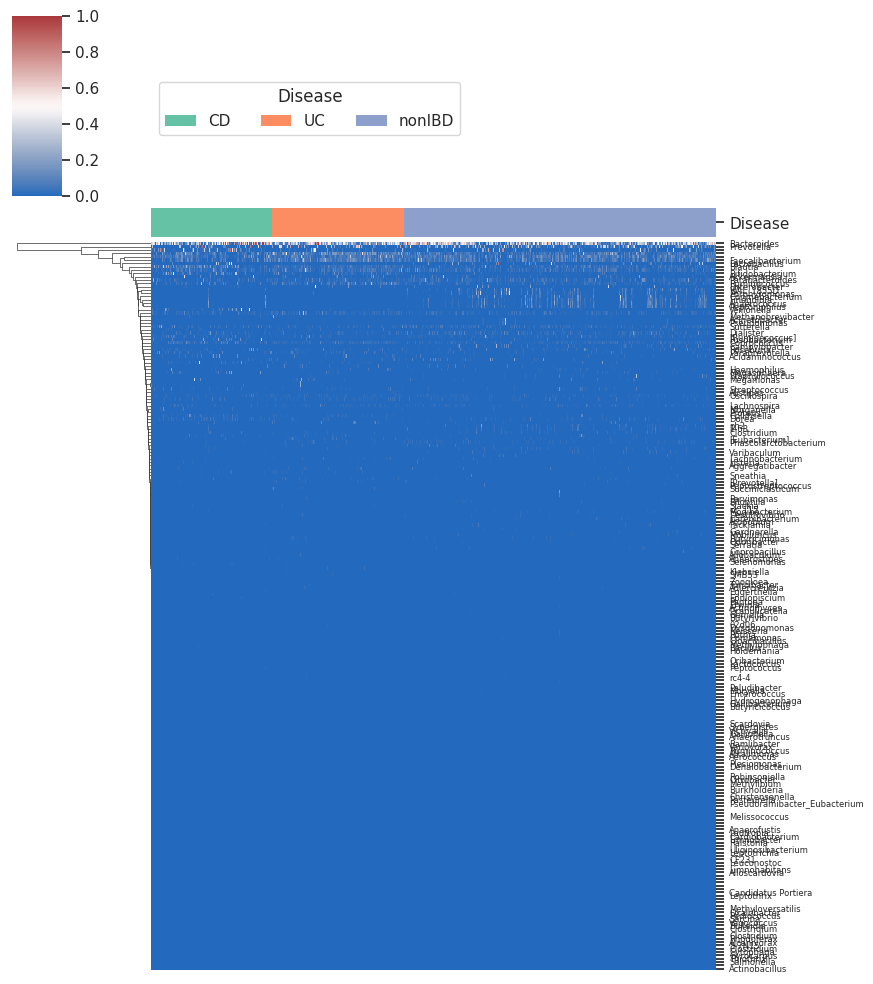

/lustre/isaac24/scratch/mhe8/myenv/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


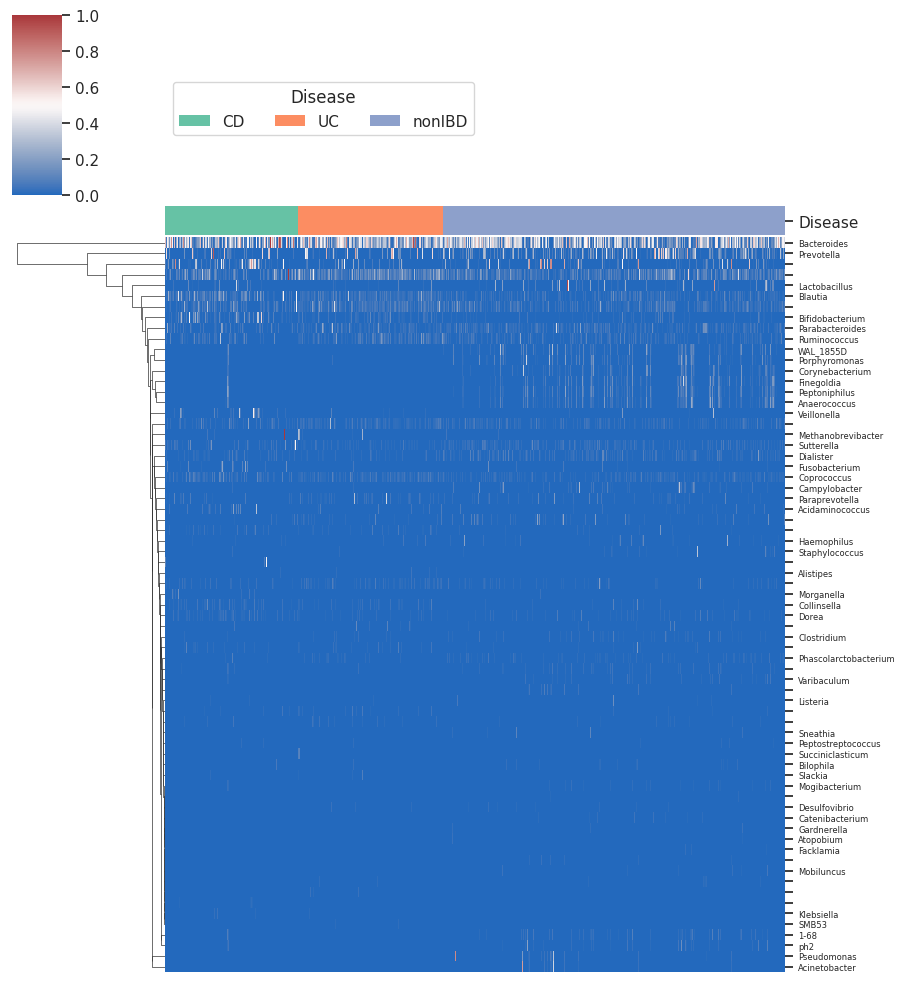

/lustre/isaac24/scratch/mhe8/myenv/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


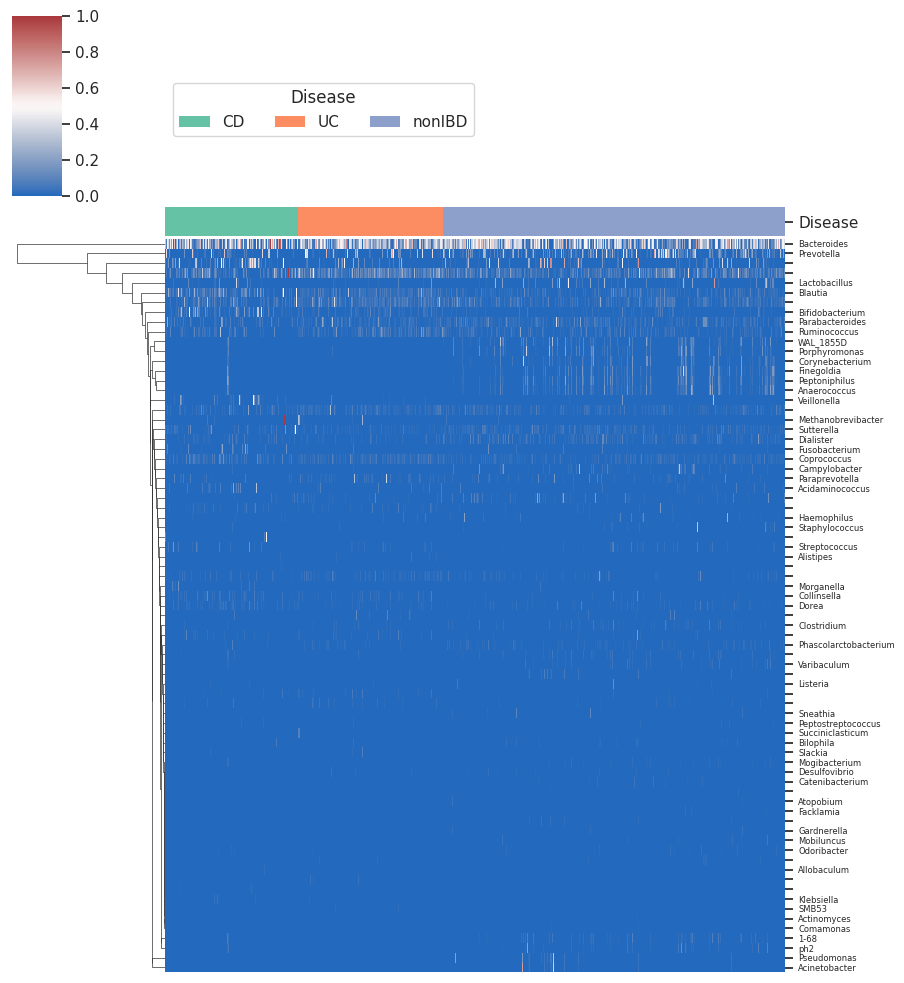

/lustre/isaac24/scratch/mhe8/myenv/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


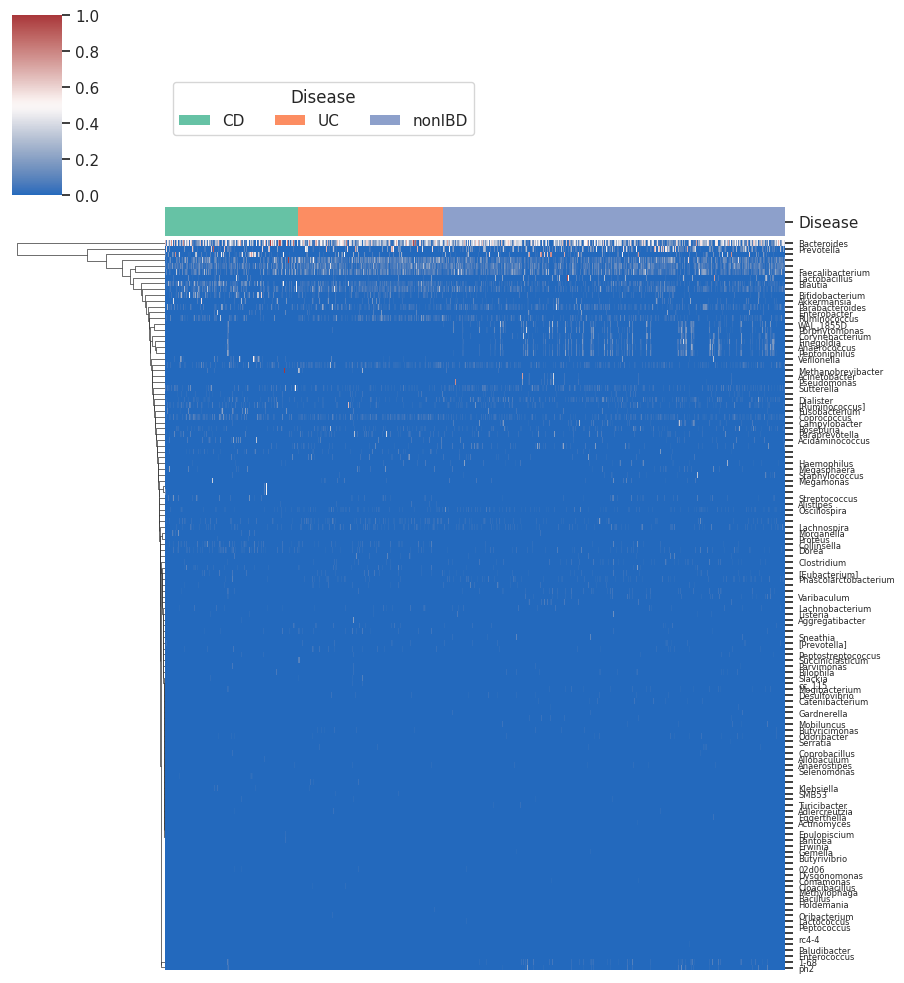

/lustre/isaac24/scratch/mhe8/myenv/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


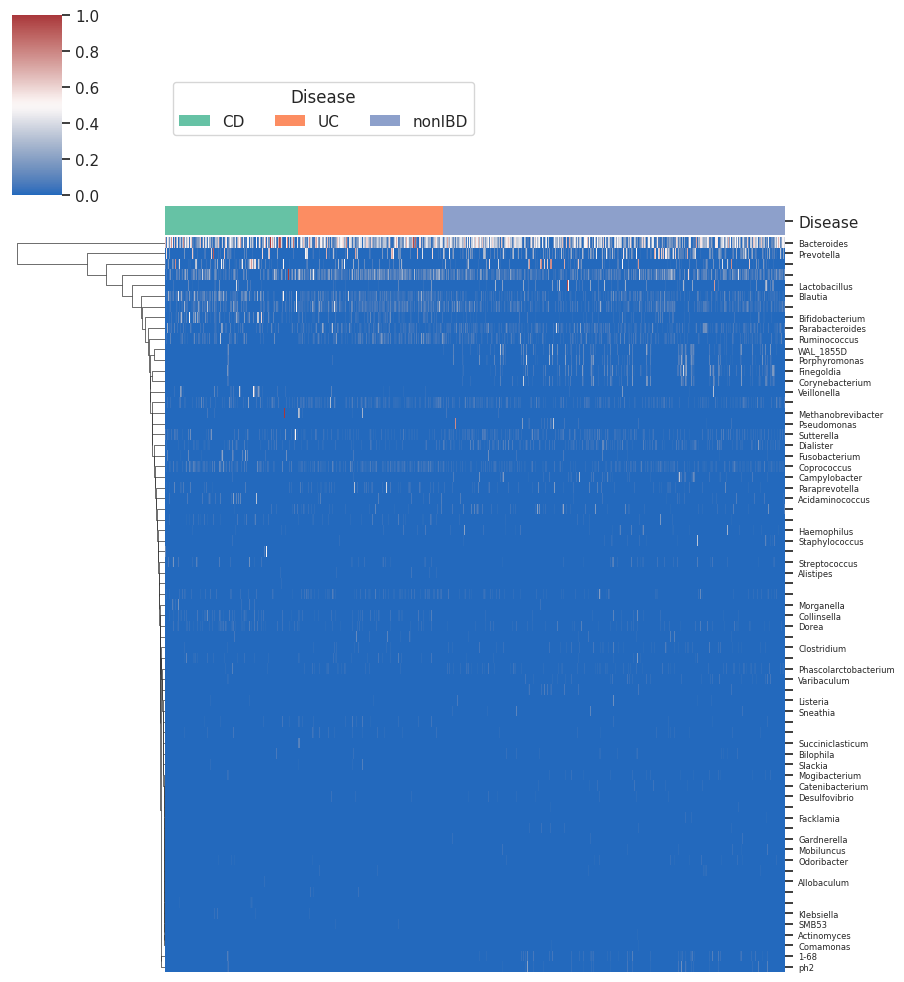

In [15]:
data_subset = loaded_dict_BG
for datatype, subset in data_subset.items():
    subset.index = meta_2.index
    #metric.plot_heatmap(subset,group_1, column_cluster = True)
    metric.plot_heatmap(subset,group_1, column_cluster = False)     



In [16]:

X_FS_strict_BG = loaded_dict_BG['SelectMicro_strict']

selectedresult_strict_BG_15 = X_FS_strict_BG.iloc[:,:20]
new_colnamesFS__BG_15 = [FS.extract_deepest_taxon_path(col) for col in selectedresult_strict_BG_15.columns]

X_FS_strict_MG = loaded_dict_MG['SelectMicro_strict']

selectedresult_strict_MG_15 = X_FS_strict_MG.iloc[:,:20]
new_colnamesFS__MG_15 = [FS.extract_deepest_taxon_path(col) for col in selectedresult_strict_MG_15.columns]


Validation passed: Dimensions are correct.
IBD= 702, nonIBD = 867


/lustre/isaac24/scratch/mhe8/SelectMicro_24/Analysis/Qitta/script/../../../Code/FS.py:451: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if label[i] == posLabel:


                          OTU  presence_pos  presence_neg
0            g__Peptoniphilus      0.011396      0.287197
1             g__Anaerococcus      0.012821      0.287197
2               g__Finegoldia      0.011396      0.265283
3          g__Bifidobacterium      0.415954      0.126874
4                      g__WAL      0.005698      0.229527
5          g__Corynebacterium      0.008547      0.234141
6            g__Porphyromonas      0.008547      0.226067
7                  g__Blautia      0.732194      0.549020
8              g__Collinsella      0.165242      0.024221
9               g__Prevotella      0.260684      0.543253
10           g__Campylobacter      0.002849      0.128028
11                    g__1-68      0.004274      0.114187
12               g__Dialister      0.209402      0.397924
13                     g__ph2      0.004274      0.087659
14              g__Sutterella      0.266382      0.433679
15             g__Veillonella      0.103989      0.019608
16  f__[Mogiba

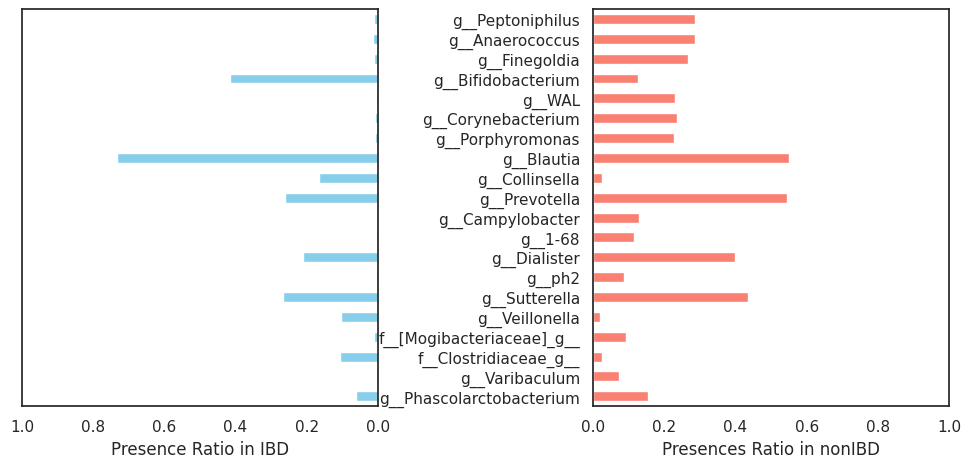

Validation passed: Dimensions are correct.
IBD= 702, nonIBD = 867
                         OTU  presence_pos  presence_neg
0           g__Peptoniphilus      0.011396      0.287197
1            g__Anaerococcus      0.012821      0.287197
2              g__Finegoldia      0.011396      0.265283
3         g__Bifidobacterium      0.415954      0.126874
4                     g__WAL      0.005698      0.229527
5         g__Corynebacterium      0.008547      0.234141
6           g__Porphyromonas      0.008547      0.226067
7     f__Ruminococcaceae_g__      0.777778      0.808535
8             g__Veillonella      0.103989      0.019608
9                 g__Blautia      0.732194      0.549020
10            g__Collinsella      0.165242      0.024221
11           g__Ruminococcus      0.451567      0.432526
12             g__Prevotella      0.260684      0.543253
13          g__Campylobacter      0.002849      0.128028
14       g__Faecalibacterium      0.692308      0.780854
15              g__Dia

/lustre/isaac24/scratch/mhe8/SelectMicro_24/Analysis/Qitta/script/../../../Code/FS.py:451: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if label[i] == posLabel:


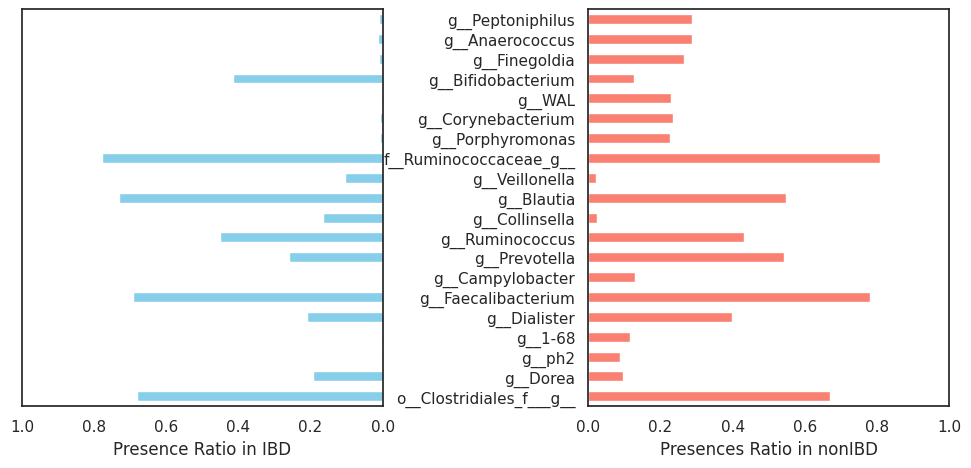

In [17]:
FS.plotPresenseRatio(np.array(selectedresult_strict_BG_15),y,new_colnamesFS__BG_15,posLabel="IBD",posText="IBD",negText="nonIBD")
FS.plotPresenseRatio(np.array(selectedresult_strict_MG_15),y,new_colnamesFS__MG_15,posLabel="IBD",posText="IBD",negText="nonIBD")

In [18]:
from matplotlib_venn import venn2
def compare_cols(df1,df2,df1_label='Df1',df2_label='Df2',short_name=True):
        # 1. Get column sets
    if short_name:
        cols1 = set(FS.extract_deepest_taxon_path(col) for col in df1.columns)
        cols2 = set(FS.extract_deepest_taxon_path(col) for col in df2.columns)
    else:
        cols1 = set(df1.columns)
        cols2 = set(df2.columns)
    
    # 2. Compute intersections and differences
    common_cols = cols1 & cols2
    only_in_df1 = cols1 - cols2
    only_in_df2 = cols2 - cols1
    
    # 3. Print results
    print(f"Common columns ({len(common_cols)}):", common_cols)
    print(f"Only in df1 ({len(only_in_df1)}):", only_in_df1)
    print(f"Only in df2 ({len(only_in_df2)}):", only_in_df2)
    
    # 4. Plot with Venn diagram
    plt.figure(figsize=(6,6))
    venn2([cols1, cols2], set_labels=(df1_label, df2_label))
    plt.title(f"Features Comparison Between {df1_label} and {df2_label}")
    plt.show()

Common columns (67): {'f__Clostridiaceae_g__', 'g__SMB53', 'f__Ruminococcaceae_g__', 'f__Rikenellaceae_g__', 'f__[Chromatiaceae]_g__', 'g__Lactobacillus', 'f__Pseudomonadaceae_g__', 'g__ph2', 'g__Coprococcus', 'g__Sutterella', 'g__Pseudomonas', 'g__Atopobium', 'g__Peptoniphilus', 'f__[Mogibacteriaceae]_g__', 'g__Slackia', 'g__1-68', 'g__Haemophilus', 'o__Bacteroidales_f___g__', 'g__Blautia', 'o__RF32_f___g__', 'g__Ruminococcus', 'g__Facklamia', 'f__Christensenellaceae_g__', 'g__Anaerococcus', 'g__Listeria', 'g__Prevotella', 'g__Collinsella', 'f__Coriobacteriaceae_g__', 'f__Comamonadaceae_g__', 'g__Methanobrevibacter', 'o__Burkholderiales_f___g__', 'g__Catenibacterium', 'g__Bilophila', 'f__[Barnesiellaceae]_g__', 'o__Clostridiales_f___g__', 'g__Dialister', 'g__Porphyromonas', 'f__[Paraprevotellaceae]_g__', 'g__Finegoldia', 'g__Acidaminococcus', 'g__Bifidobacterium', 'g__Peptostreptococcus', 'g__Varibaculum', 'g__Sneathia', 'g__Gardnerella', 'g__Fusobacterium', 'g__Paraprevotella', 'g__S

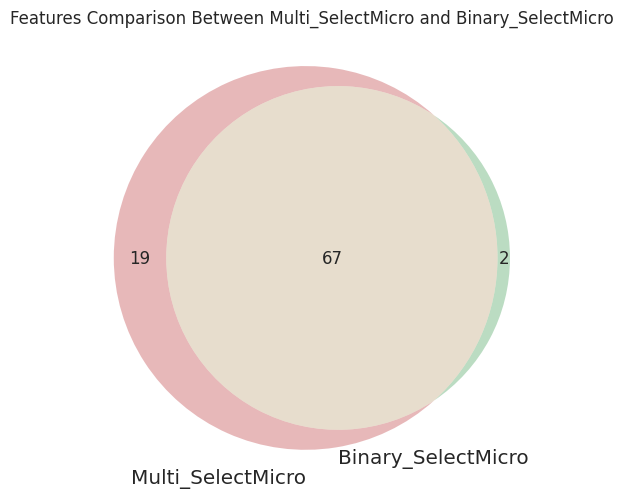

Common columns (126): {'g__SMB53', 'f__Ruminococcaceae_g__', 'f__Rikenellaceae_g__', 'g__Lactobacillus', 'g__Cloacibacillus', 'g__Coprococcus', 'g__ph2', 'g__Pseudomonas', 'g__Haemophilus', 'g__Desulfovibrio', 'o__RF39_f___g__', 'g__Aggregatibacter', 'o__Burkholderiales_f___g__', 'g__Bilophila', 'g__Porphyromonas', 'g__cc', 'g__Finegoldia', 'g__Proteus', 'g__Peptostreptococcus', 'g__Enterobacter', 'g__Fusobacterium', 'g__Succiniclasticum', 'g__Bacteroides', 'g__rc4-4', 'g__Butyrivibrio', 'o__ML615J-28_f___g__', 'g__Erwinia', 'g__Dorea', 'f__Bifidobacteriaceae_g__', 'g__Clostridium', 'g__Veillonella', 'g__Lactococcus', 'g__Faecalibacterium', 'f__[Chromatiaceae]_g__', 'g__Coprobacillus', 'f__Pseudomonadaceae_g__', 'g__Turicibacter', 'g__Methylophaga', 'g__Ruminococcus', 'g__Adlercreutzia', 'o__Thiohalorhabdales_f___g__', 'g__Odoribacter', 'g__Oribacterium', 'g__Lachnobacterium', 'g__Bacillus', 'f__Veillonellaceae_g__', 'g__Mobiluncus', 'g__Paraprevotella', 'f__Peptostreptococcaceae_g__',

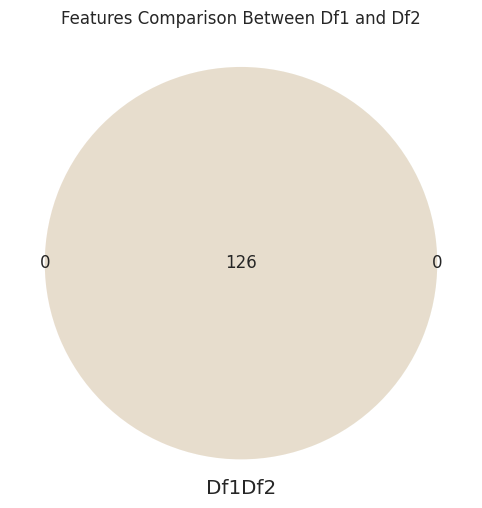

Common columns (84): {'g__SMB53', 'f__Ruminococcaceae_g__', 'f__Rikenellaceae_g__', 'g__Lactobacillus', 'g__ph2', 'g__Coprococcus', 'g__Cloacibacillus', 'g__Pseudomonas', 'g__Haemophilus', 'o__Burkholderiales_f___g__', 'g__Bilophila', 'g__Porphyromonas', 'g__cc', 'g__Finegoldia', 'g__Proteus', 'g__Peptostreptococcus', 'g__Fusobacterium', 'g__Succiniclasticum', 'g__Bacteroides', 'o__ML615J-28_f___g__', 'g__Dorea', 'f__Bifidobacteriaceae_g__', 'g__Clostridium', 'g__Veillonella', 'g__Faecalibacterium', 'f__[Chromatiaceae]_g__', 'f__Pseudomonadaceae_g__', 'g__Ruminococcus', 'g__Lachnobacterium', 'g__Mobiluncus', 'g__Paraprevotella', 'f__Peptostreptococcaceae_g__', 'g__Butyricimonas', 'f__Enterobacteriaceae_g__', 'g__Pantoea', 'g__WAL', 'g__[Eubacterium]', 'f__Clostridiaceae_g__', 'g__Megasphaera', 'g__Sutterella', 'g__Peptoniphilus', 'f__[Mogibacteriaceae]_g__', 'g__Slackia', 'g__1-68', 'o__RF32_f___g__', 'f__Christensenellaceae_g__', 'g__Prevotella', 'g__Streptococcus', 'f__Comamonadaceae

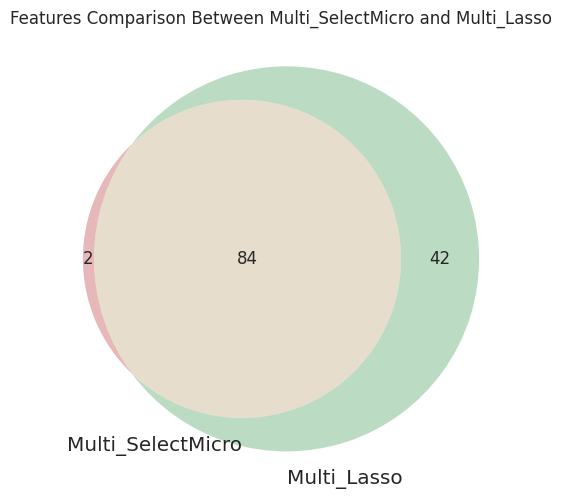

In [19]:
# compare multi vs. binary in select 0.5 genus

compare_cols(loaded_dict_MG['SelectMicro_strict'],loaded_dict_BG['SelectMicro_strict'],df1_label='Multi_SelectMicro',df2_label='Binary_SelectMicro')
# compare multi vs. binary in Lassogenus
compare_cols(loaded_dict_MG['Lasso_finetune'],loaded_dict_BG['Lasso_finetune'])

# compare multi  select 0.5 and Lasso genus
compare_cols(loaded_dict_MG['SelectMicro_strict'],loaded_dict_MG['Lasso_finetune']
             ,df1_label='Multi_SelectMicro',df2_label='Multi_Lasso')


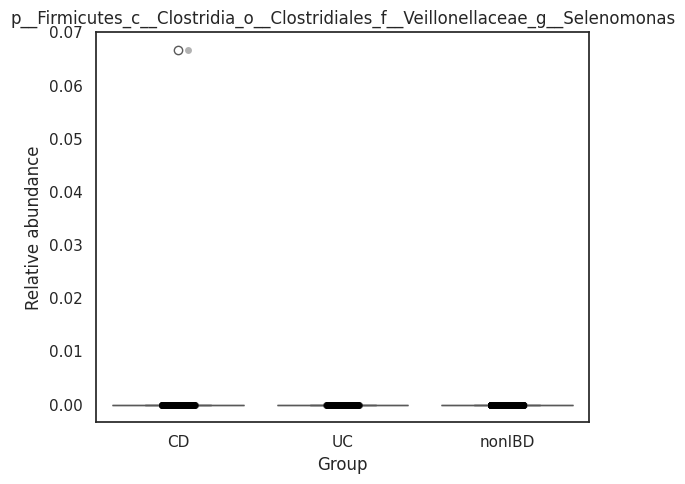

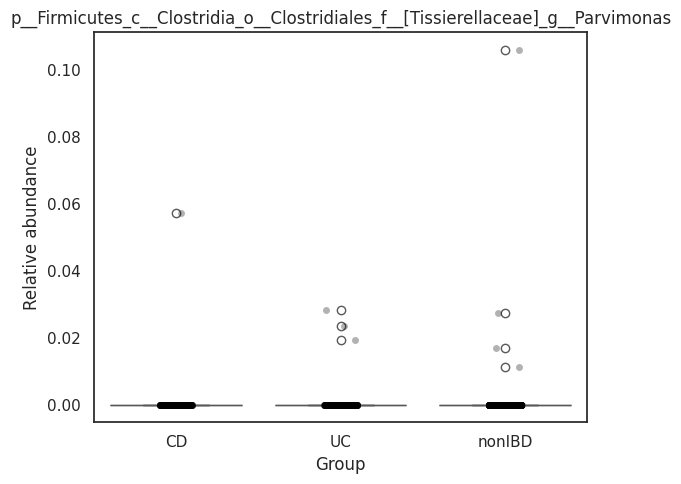

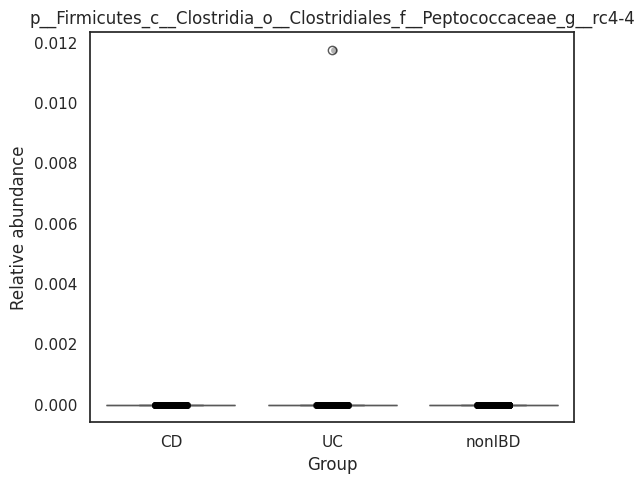

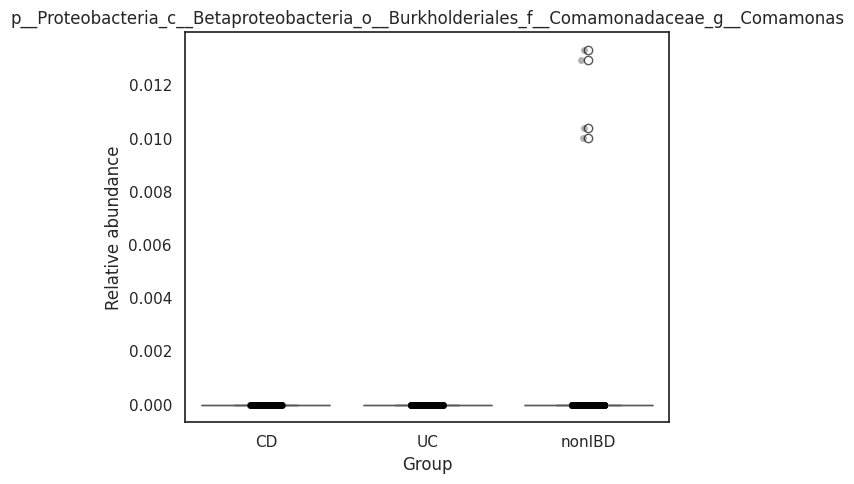

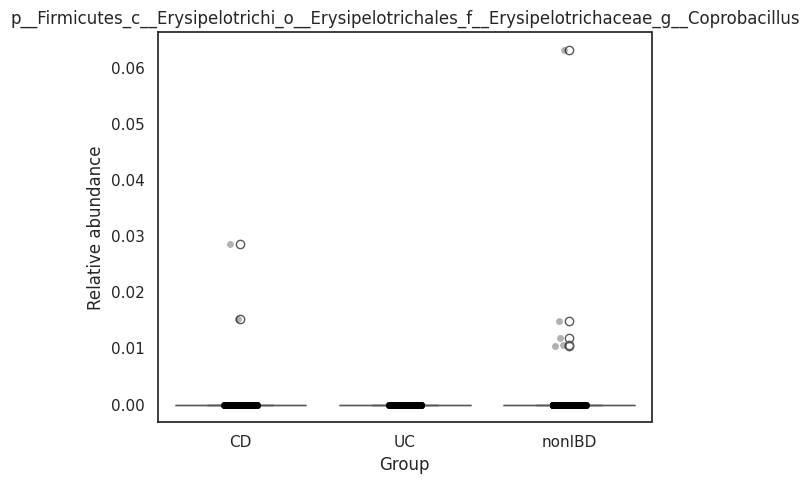

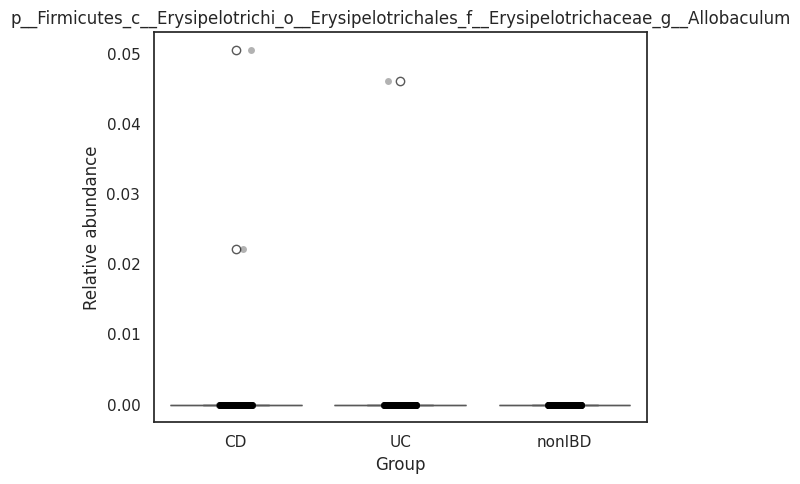

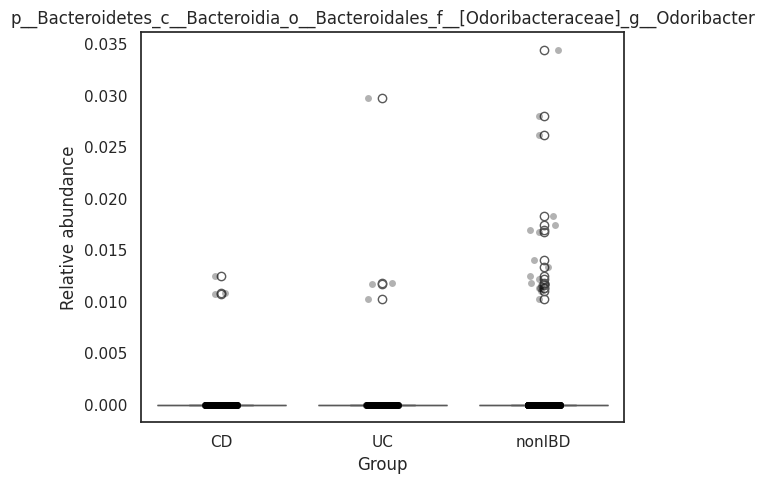

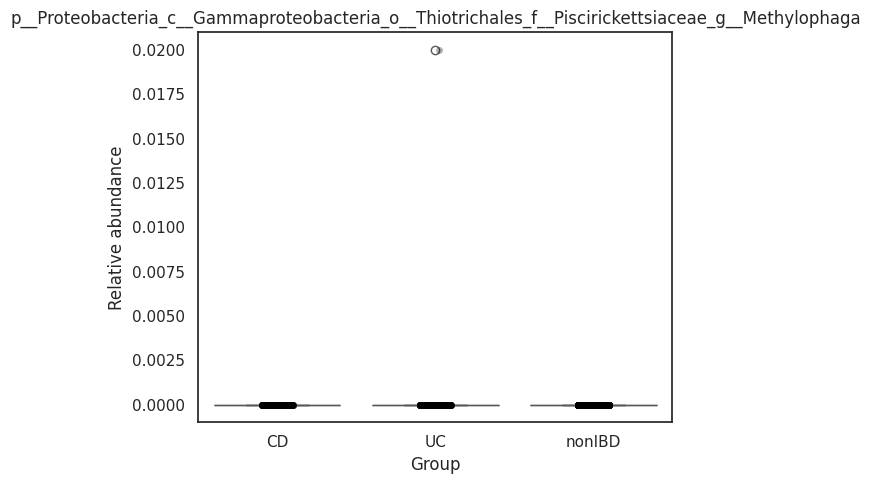

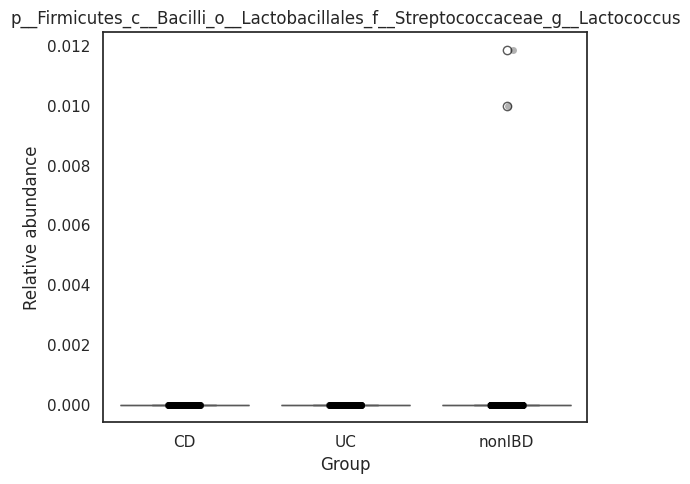

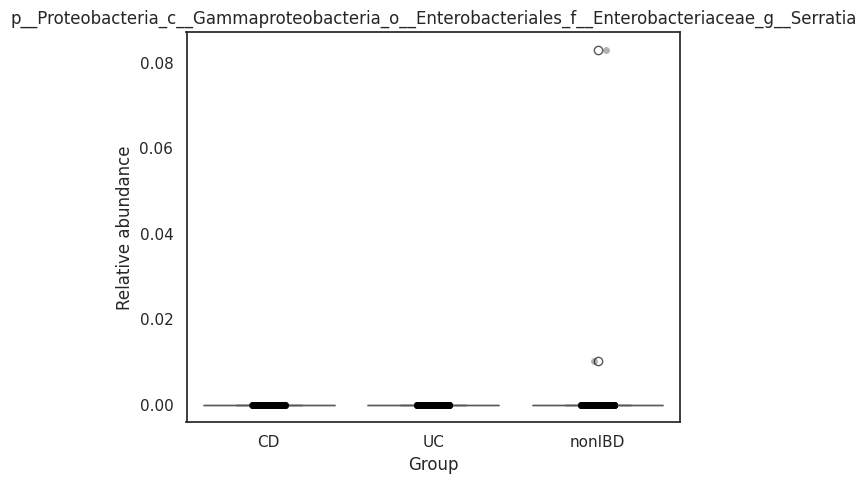

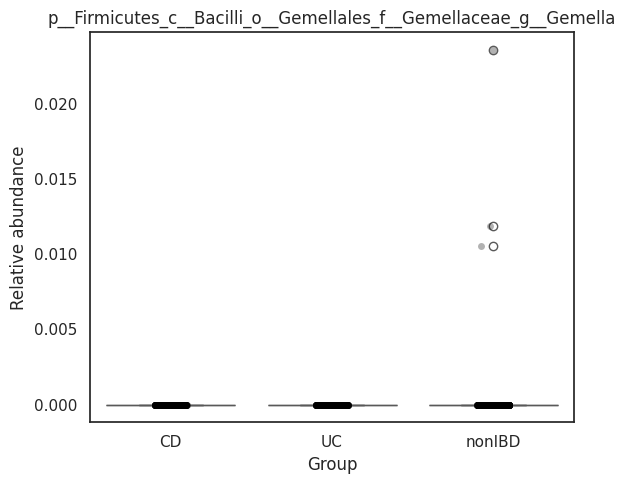

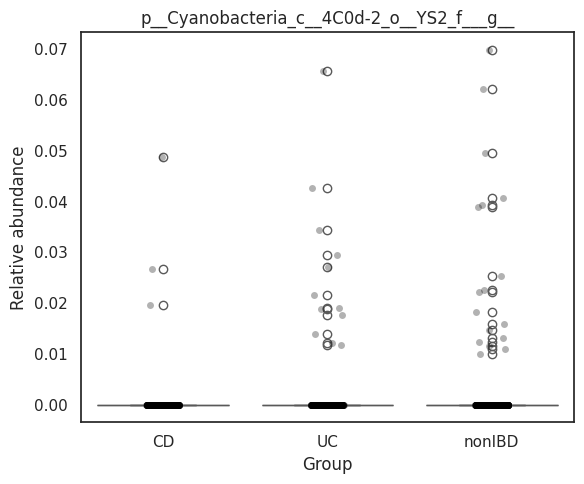

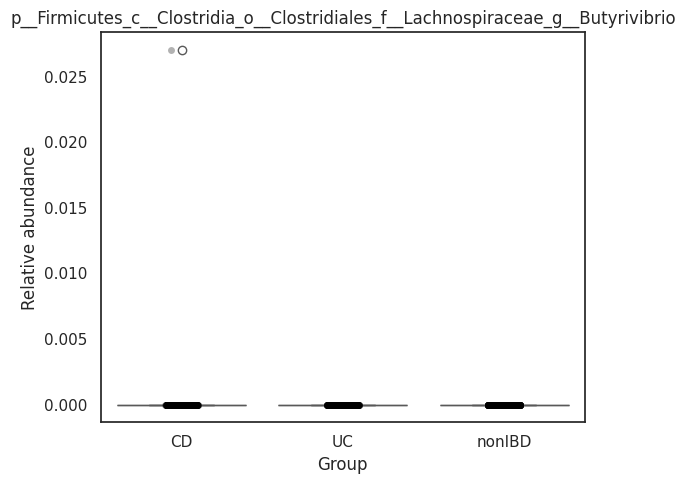

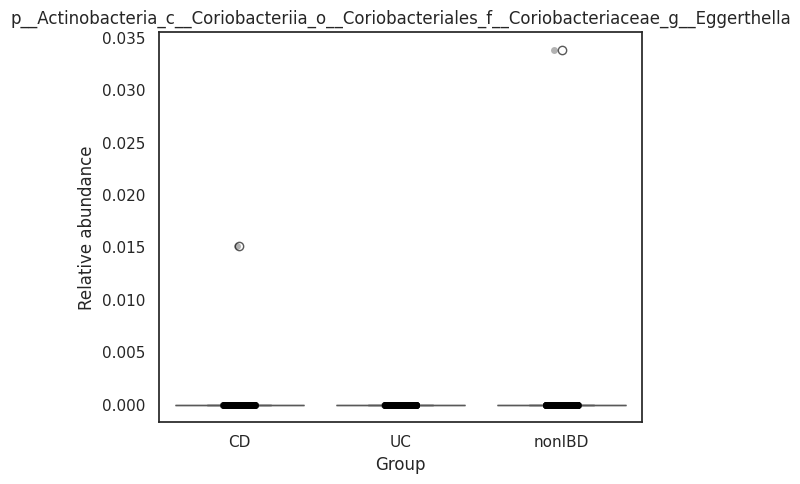

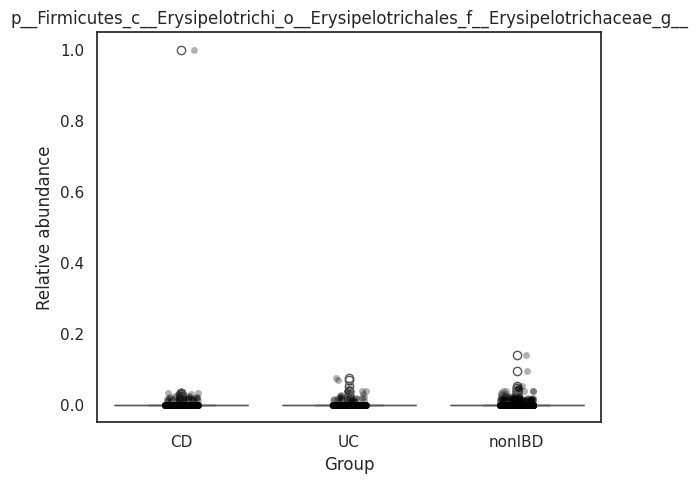

In [20]:
# check only in Lasso
feature_list_onlylasso = ['p__Firmicutes_c__Clostridia_o__Clostridiales_f__Veillonellaceae_g__Selenomonas', 'p__Firmicutes_c__Clostridia_o__Clostridiales_f__[Tissierellaceae]_g__Parvimonas', 'p__Firmicutes_c__Clostridia_o__Clostridiales_f__Peptococcaceae_g__rc4-4', 'p__Proteobacteria_c__Betaproteobacteria_o__Burkholderiales_f__Comamonadaceae_g__Comamonas', 'p__Firmicutes_c__Erysipelotrichi_o__Erysipelotrichales_f__Erysipelotrichaceae_g__Coprobacillus', 'p__Firmicutes_c__Erysipelotrichi_o__Erysipelotrichales_f__Erysipelotrichaceae_g__Allobaculum', 'p__Bacteroidetes_c__Bacteroidia_o__Bacteroidales_f__[Odoribacteraceae]_g__Odoribacter', 'p__Proteobacteria_c__Gammaproteobacteria_o__Thiotrichales_f__Piscirickettsiaceae_g__Methylophaga', 'p__Firmicutes_c__Bacilli_o__Lactobacillales_f__Streptococcaceae_g__Lactococcus', 'p__Proteobacteria_c__Gammaproteobacteria_o__Enterobacteriales_f__Enterobacteriaceae_g__Serratia', 'p__Firmicutes_c__Bacilli_o__Gemellales_f__Gemellaceae_g__Gemella', 'p__Cyanobacteria_c__4C0d-2_o__YS2_f___g__', 'p__Firmicutes_c__Clostridia_o__Clostridiales_f__Lachnospiraceae_g__Butyrivibrio', 'p__Actinobacteria_c__Coriobacteriia_o__Coriobacteriales_f__Coriobacteriaceae_g__Eggerthella', 'p__Firmicutes_c__Erysipelotrichi_o__Erysipelotrichales_f__Erysipelotrichaceae_g__']

for feature in feature_list_onlylasso:
    sample = loaded_dict_MG['Lasso_finetune'][[feature]].copy()
    sample['Group'] = y_label.values
    plt.figure(figsize=(6, 5))
    sns.boxplot(data=sample, x='Group', y=feature, hue='Group', palette='Set2', legend=False)
    sns.stripplot(data=sample, x='Group', y=feature, color='black', alpha=0.3, jitter=True)
    plt.ylabel("Relative abundance")  # Replace with your desired title
    plt.title(f"{feature}")
    plt.tight_layout()
    plt.show()

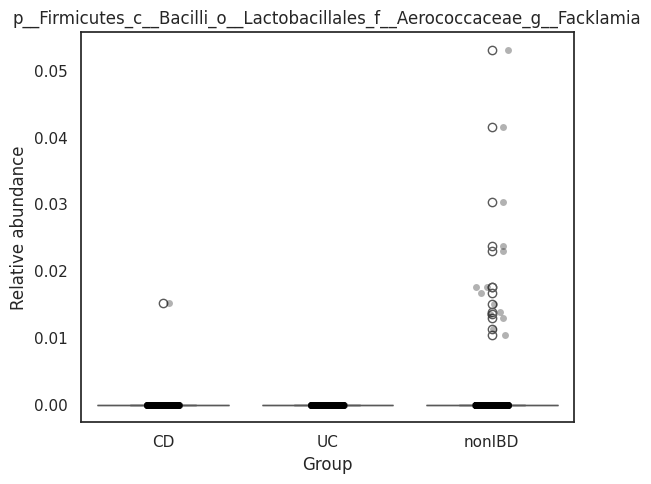

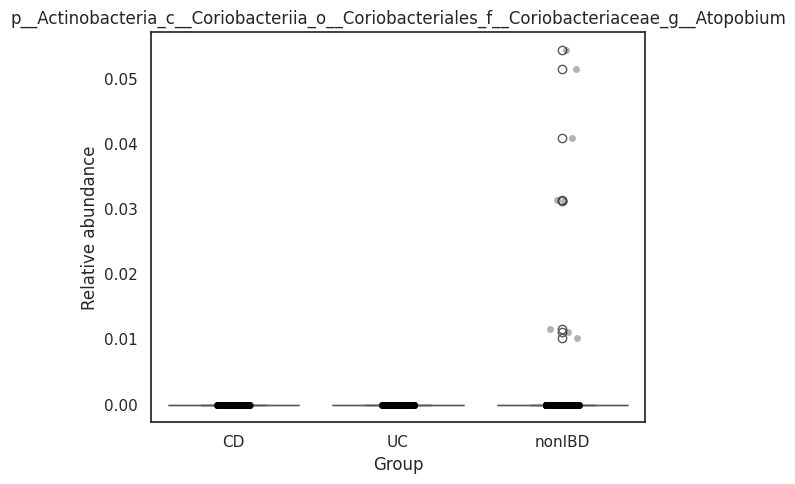

In [21]:
# check only in Selectmicro
feature_list_onlyfs =['p__Firmicutes_c__Bacilli_o__Lactobacillales_f__Aerococcaceae_g__Facklamia', 'p__Actinobacteria_c__Coriobacteriia_o__Coriobacteriales_f__Coriobacteriaceae_g__Atopobium']
for feature in feature_list_onlyfs:
    sample = loaded_dict_MG['SelectMicro_strict'][[feature]].copy()
    sample['Group'] = y_label.values
    plt.figure(figsize=(6, 5))
    sns.boxplot(data=sample, x='Group', y=feature, hue='Group', palette='Set2', legend=False)
    sns.stripplot(data=sample, x='Group', y=feature, color='black', alpha=0.3, jitter=True)
    plt.ylabel("Relative abundance")  # Replace with your desired title
    plt.title(f"{feature}")
    plt.tight_layout()
    plt.show()

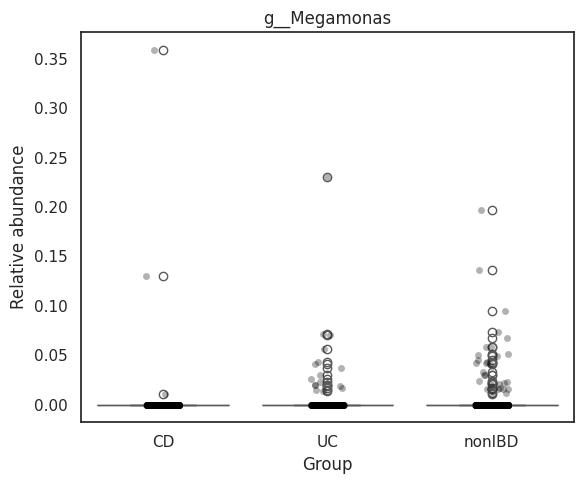

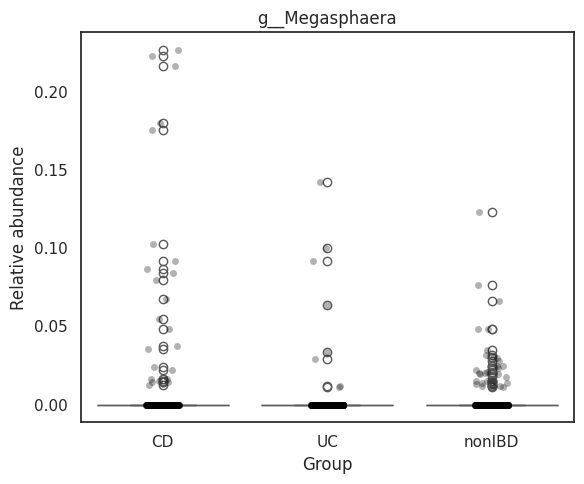

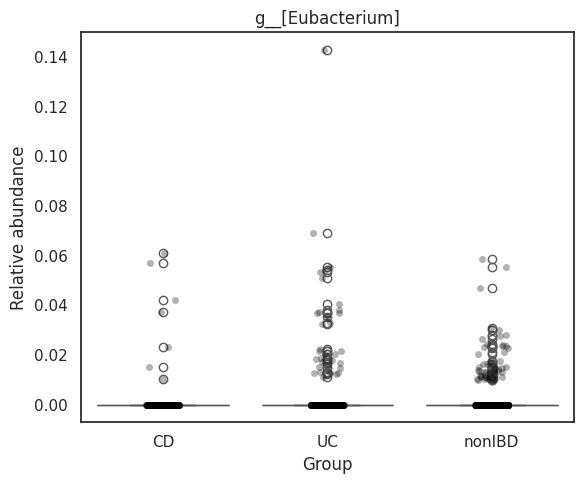

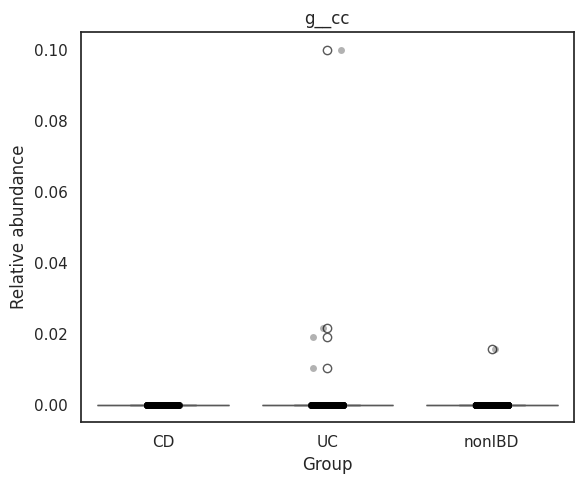

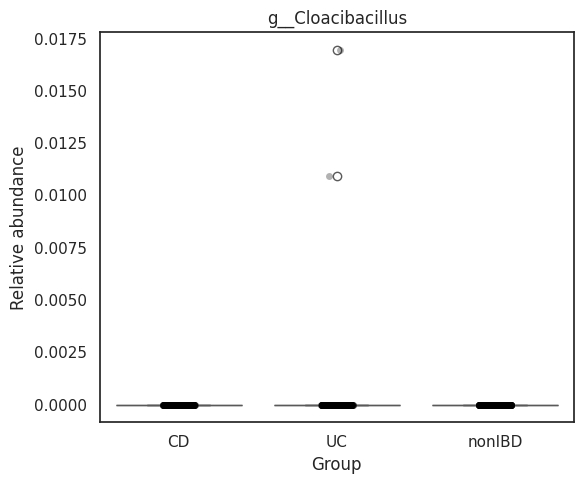

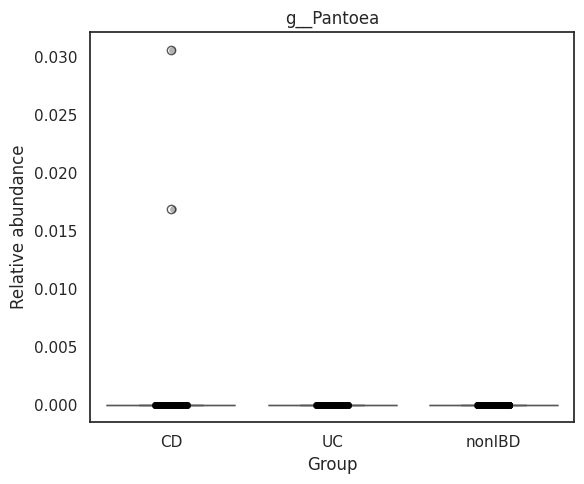

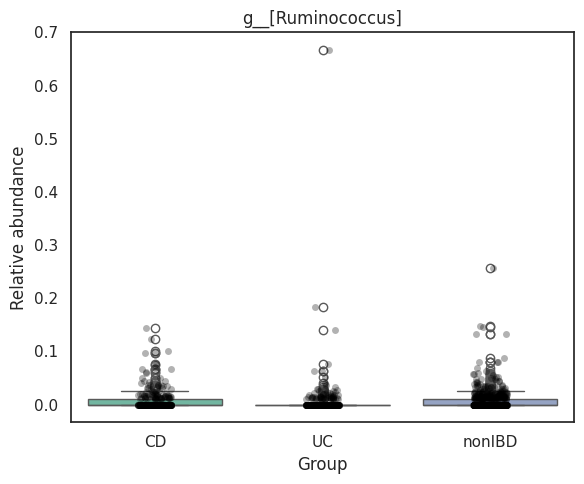

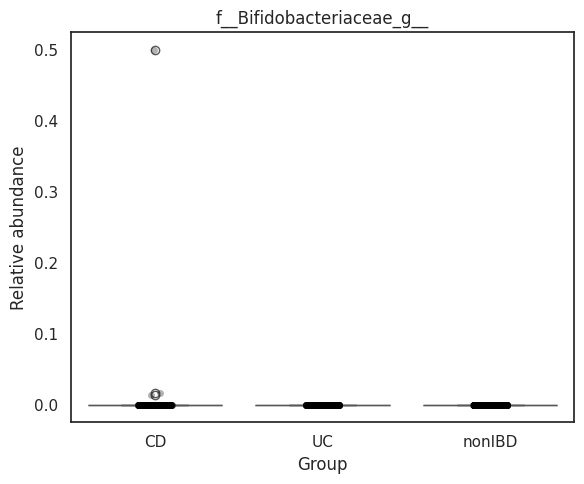

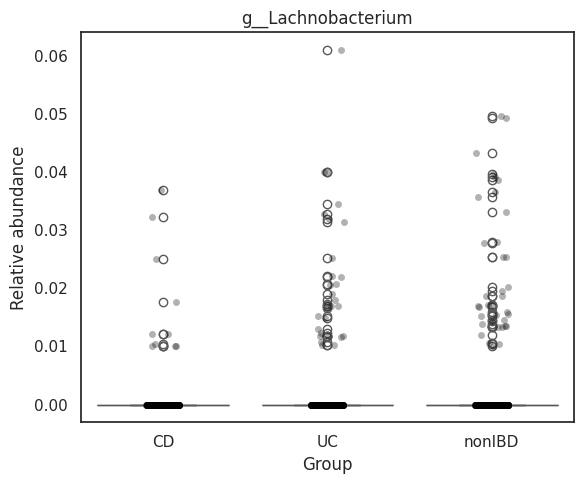

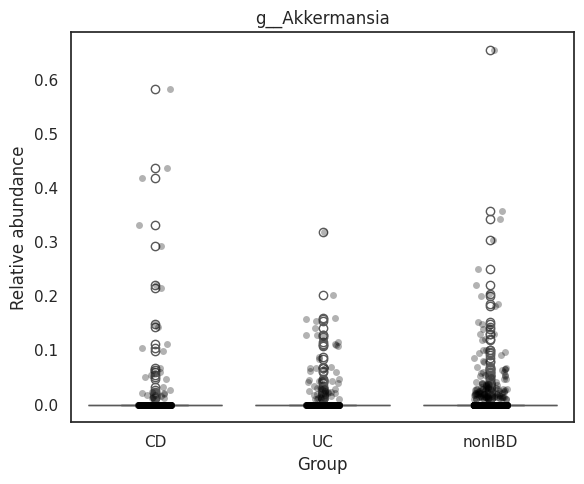

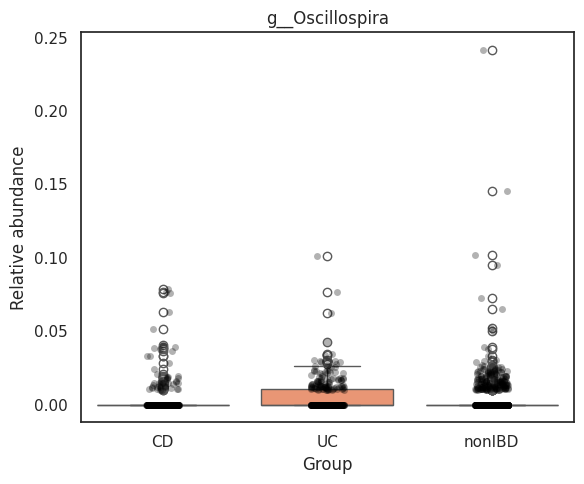

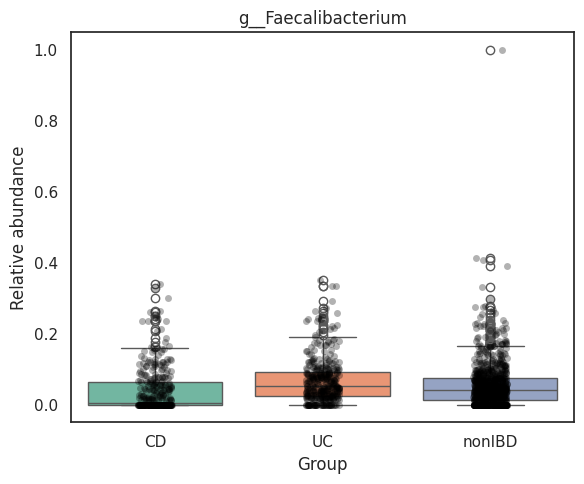

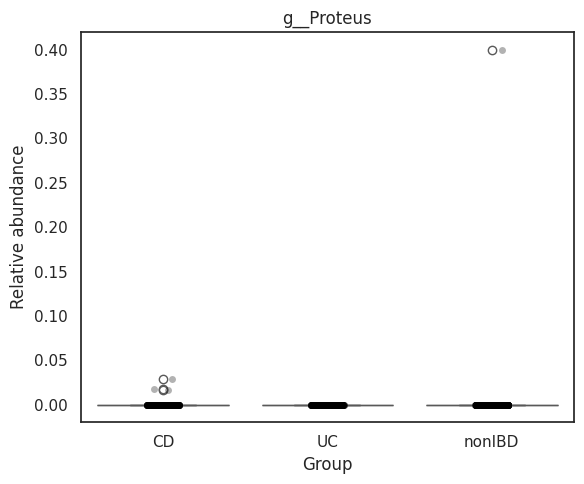

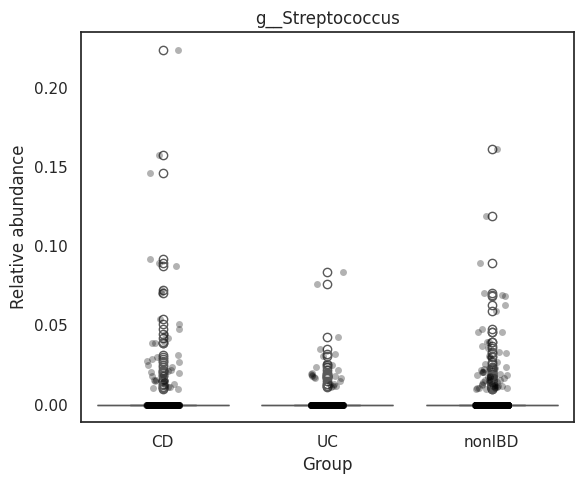

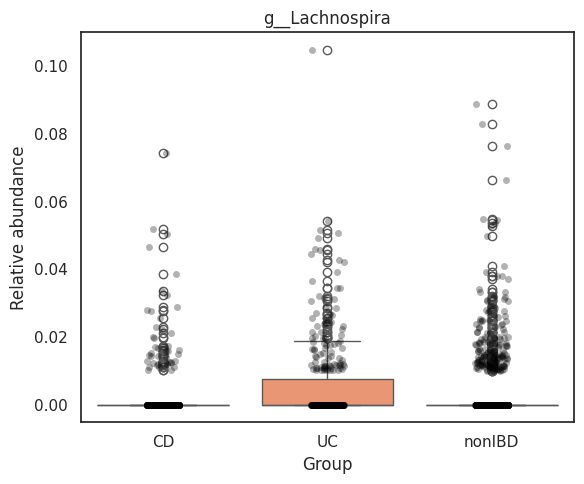

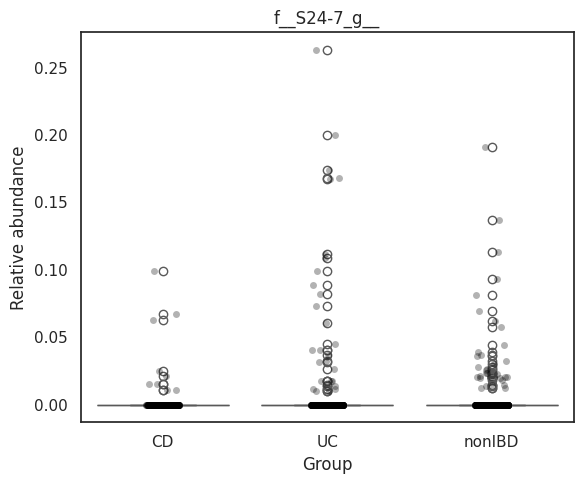

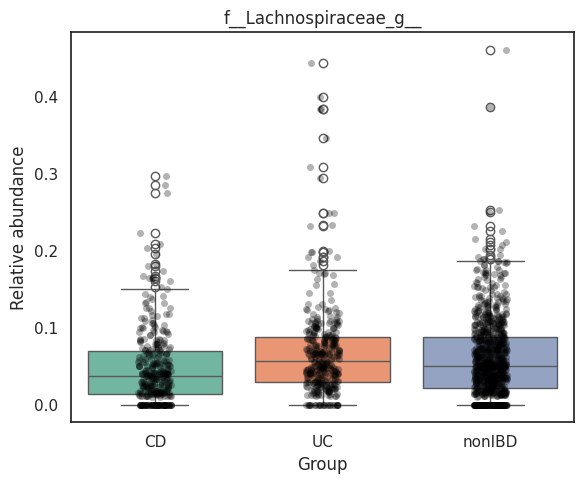

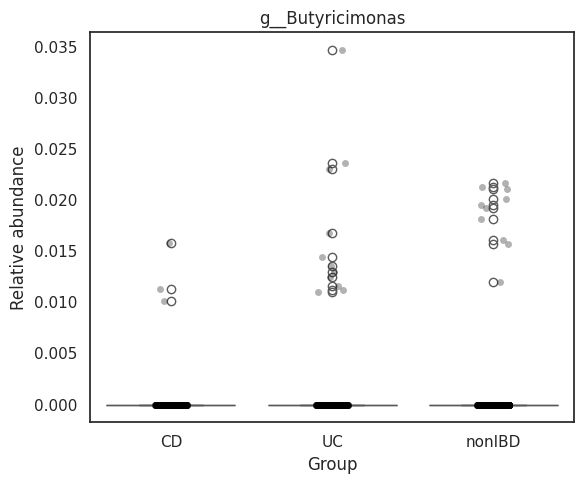

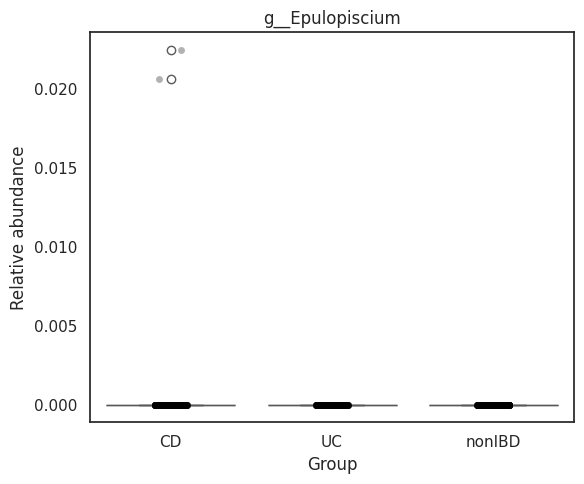

In [22]:
# only in multi

feature_list_onlymulti_fs= ['g__Megamonas', 'g__Megasphaera', 'g__[Eubacterium]', 'g__cc', 'g__Cloacibacillus', 'g__Pantoea', 'g__[Ruminococcus]', 'f__Bifidobacteriaceae_g__', 'g__Lachnobacterium', 'g__Akkermansia', 'g__Oscillospira', 'g__Faecalibacterium', 'g__Proteus', 'g__Streptococcus', 'g__Lachnospira', 'f__S24-7_g__', 'f__Lachnospiraceae_g__', 'g__Butyricimonas', 'g__Epulopiscium']
for feature in feature_list_onlymulti_fs:
    data = loaded_dict_MG['SelectMicro_strict']
    data.columns = [FS.extract_deepest_taxon_path(col) for col in data.columns]
    sample = loaded_dict_MG['SelectMicro_strict'][[feature]].copy()
    sample['Group'] = y_label.values
    plt.figure(figsize=(6, 5))
    sns.boxplot(data=sample, x='Group', y=feature, hue='Group', palette='Set2', legend=False)
    sns.stripplot(data=sample, x='Group', y=feature, color='black', alpha=0.3, jitter=True)
    plt.ylabel("Relative abundance")  # Replace with your desired title
    plt.title(f"{feature}")
    plt.tight_layout()
    plt.show()

### Modeling

In [23]:
y_label

11484.CSM5FZ3X        CD
11484.CSM5FZ3Z        CD
11484.MSM5LLIQ        UC
11484.CSM5FZ3N        CD
11484.CSM5MCV5        CD
                   ...  
2151.G10483       nonIBD
2151.G11579       nonIBD
2151.G11295       nonIBD
2151.G11157       nonIBD
2151.G10686       nonIBD
Name: ibd, Length: 1569, dtype: object

In [24]:
# plot the family 
for datatype, subset in data_subset_list[0].items():   
    RunML.plot_dim_reduction(subset, y, method='PCA',datalabel=datatype)

NameError: name 'data_subset_list' is not defined

In [ ]:
# plot the genus 
for datatype, subset in data_subset_list[1].items():    
     RunML.plot_dim_reduction(subset, y, method='PCA',datalabel=datatype)

In [32]:
X_FS_strict_MG = loaded_dict_MG['SelectMicro_strict']


dunn_results, summary = FS.calculate_dunn_tests_pair(
    X_FS_strict_MG,
    y_label,
    p_threshold=0.05
)

In [33]:
summary['Feature'] = summary['Feature'].apply(FS.extract_deepest_taxon_path)
# Set pandas to display all rows
pd.set_option('display.max_rows', None)
# Assuming your dataframe is named df
print(summary)
# Optionally, reset back to default if needed
pd.reset_option('display.max_rows')

                          Feature Group1  Group2       P-value EffectDirection
0                g__Peptoniphilus     CD  nonIBD  1.129499e-28               =
1                g__Peptoniphilus     UC  nonIBD  1.550792e-33               =
2                 g__Anaerococcus     CD  nonIBD  1.463387e-27               =
3                 g__Anaerococcus     UC  nonIBD  6.317445e-34               =
4                   g__Finegoldia     CD  nonIBD  1.628109e-25               =
5                   g__Finegoldia     UC  nonIBD  6.088022e-31               =
6              g__Bifidobacterium     CD  nonIBD  1.088344e-25               =
7              g__Bifidobacterium     UC  nonIBD  5.210812e-29               =
8                          g__WAL     CD  nonIBD  3.581021e-23               =
9                          g__WAL     UC  nonIBD  2.659664e-27               =
10             g__Corynebacterium     CD  nonIBD  5.507976e-23               =
11             g__Corynebacterium     UC  nonIBD  5.

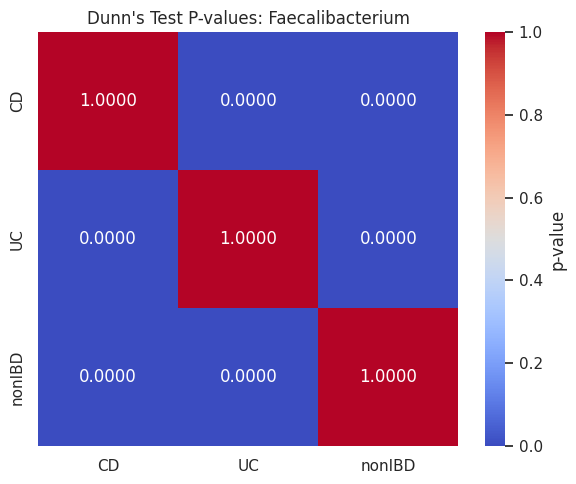

In [34]:
plt.figure(figsize=(6, 5))
sns.heatmap(dunn_results["g__Faecalibacterium"].astype(float), annot=True, cmap='coolwarm', fmt=".4f", cbar_kws={'label': 'p-value'})
plt.title(f"Dunn's Test P-values: Faecalibacterium")
plt.tight_layout()
plt.show()

                          Feature  Group1  Group2       P-value  \
0                g__Peptoniphilus       0       1  1.129499e-28   
1                g__Peptoniphilus       0       2  1.550792e-33   
2                 g__Anaerococcus       0       1  1.463387e-27   
3                 g__Anaerococcus       0       2  6.317445e-34   
4                   g__Finegoldia       0       1  1.628109e-25   
5                   g__Finegoldia       0       2  6.088022e-31   
6              g__Bifidobacterium       0       1  1.088344e-25   
7              g__Bifidobacterium       0       2  5.210812e-29   
8                          g__WAL       0       1  3.581021e-23   
9                          g__WAL       0       2  2.659664e-27   
10             g__Corynebacterium       0       1  5.507976e-23   
11             g__Corynebacterium       0       2  5.250325e-27   
12               g__Porphyromonas       0       1  2.840019e-23   
13               g__Porphyromonas       0       2  6.672331e-2

In [ ]:
#subset_OTU_12 = summary[summary['Group1'] == 1]['Feature'].unique()# select those are only differet between 1 and 2
subset_OTU_12 = (
    summary[summary['Group1'] == 1]
    .groupby('Feature')
    .filter(lambda x: len(x) == 1)
    ['Feature']
    .unique()
)

# select some of the features
for feature in subset_OTU_12:
    df_dunntest_x = X_FS_strict_MG[[feature]].copy()
    df_dunntest_x['Group'] = y_label.values
    plt.figure(figsize=(6, 5))
    sns.boxplot(data=df_dunntest_x, x='Group', y=feature, hue='Group', palette='Set2', legend=False)
    sns.stripplot(data=df_dunntest_x, x='Group', y=feature, color='black', alpha=0.3, jitter=True)
    plt.ylabel("Relative abundance")  # Replace with your desired title
    plt.title(f"{feature}")
    plt.tight_layout()
    plt.show()

## compare the first 15 index

In [ ]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
# the   df with the largest H statistics features
entries=15
selectedOTU_index_15=selectedOTU_index[:entries]
X_FS_15=data[:,selectedOTU_index_15]
df=pd.DataFrame(data=X_FS_15)


In [ ]:
# the column names of the featues
ASVs = cols_name
selectedASVs=[ASVs[i] for i in selectedOTU_index_15]

In [ ]:
print(set(targetLabel))
RunML.plotPresenseRatio(X_FS_15,targetLabel,selectedASVs,posLabel="IBD",posText="IBD",negText="nonIBD",entries=entries)

In [ ]:
selectedASV_lasso = [cols_name[i] for i in xlabel_lasso]
RunML.plotPresenseRatio(X_lasso,targetLabel,selectedASV_lasso,posLabel="IBD",posText="IBD",negText="nonIBD",entries=len(selectedASV_lasso))

In [41]:
import RunModel
import os
subset_FS_MG = loaded_dict_MG['SelectMicro_strict']
subset_FS_MG.columns = [FS.extract_deepest_taxon_path(col) for col in subset_FS_MG.columns]
subset_FS_MG.columns = subset_FS_MG.columns.astype(str).str.replace(r"[\[\]<>]", "_", regex=True)

dict_cm = RunModel.XG_model_SCV_multi(subset_FS_MG, target_variable_1,SMOTE=True,k=5)

The combined confusion matrix
[[740  41  86]
 [ 54 212  70]
 [ 72  53 241]]
Mean Accuracy: 0.760 (0.032),Mean F1: 0.760 (0.031),Mean MCC: 0.588 (0.052),  Mean AUC: 0.897 (0.015)


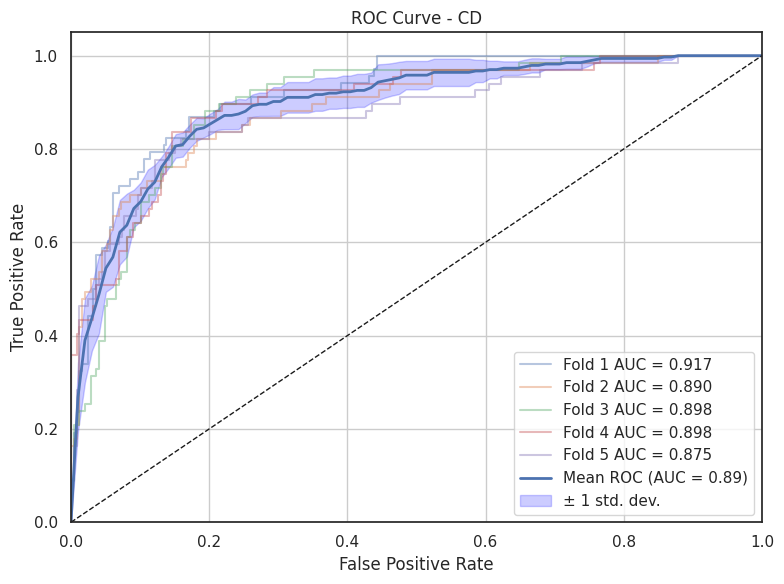

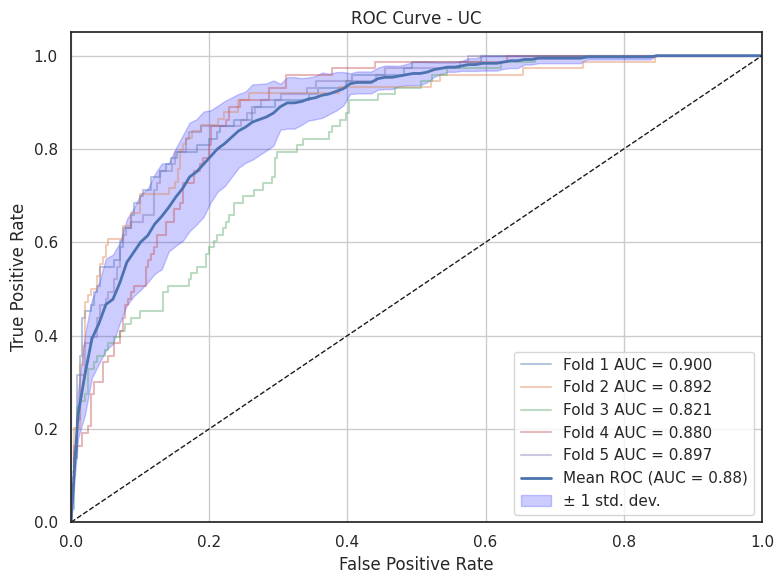

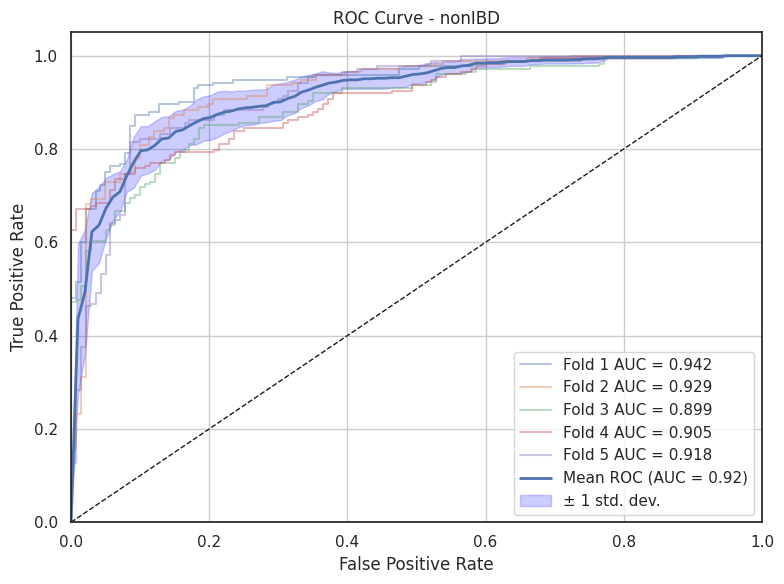

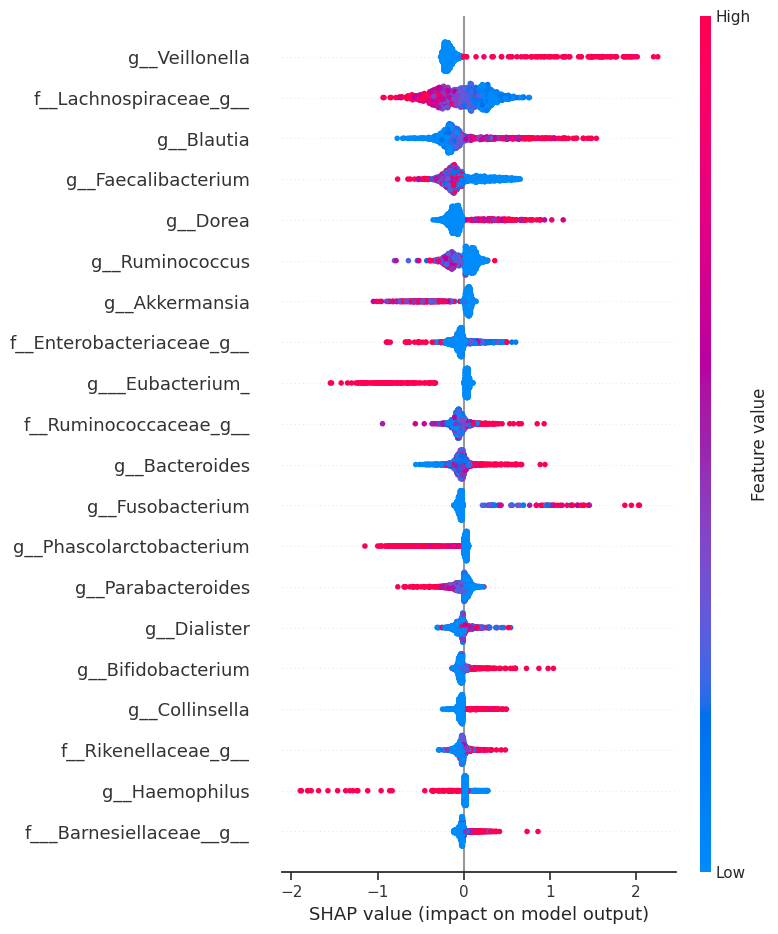

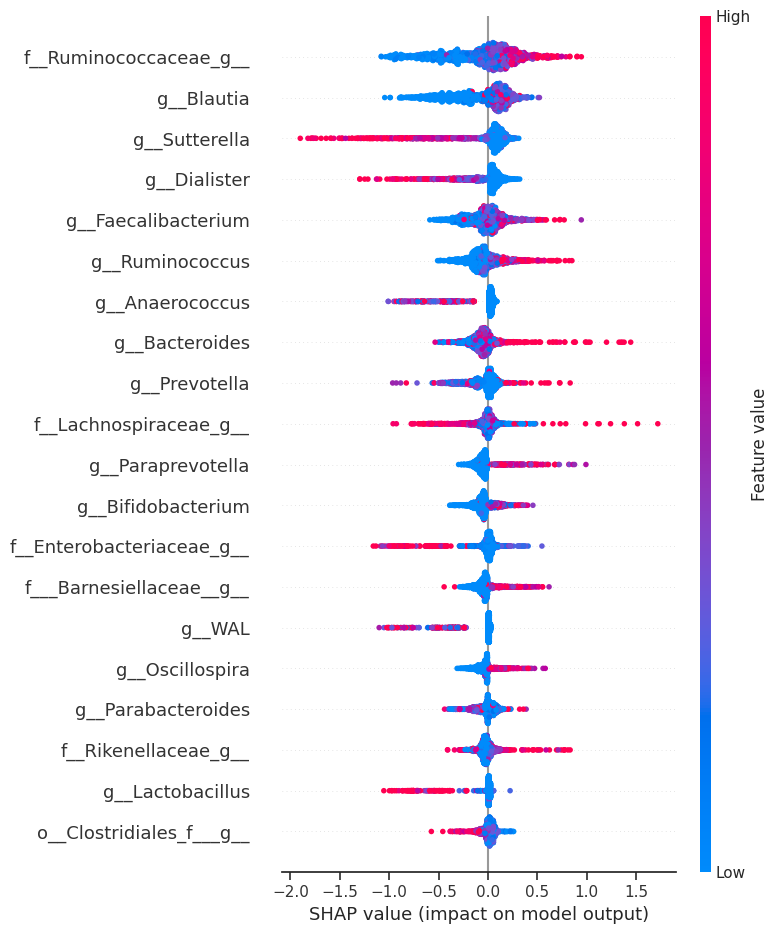

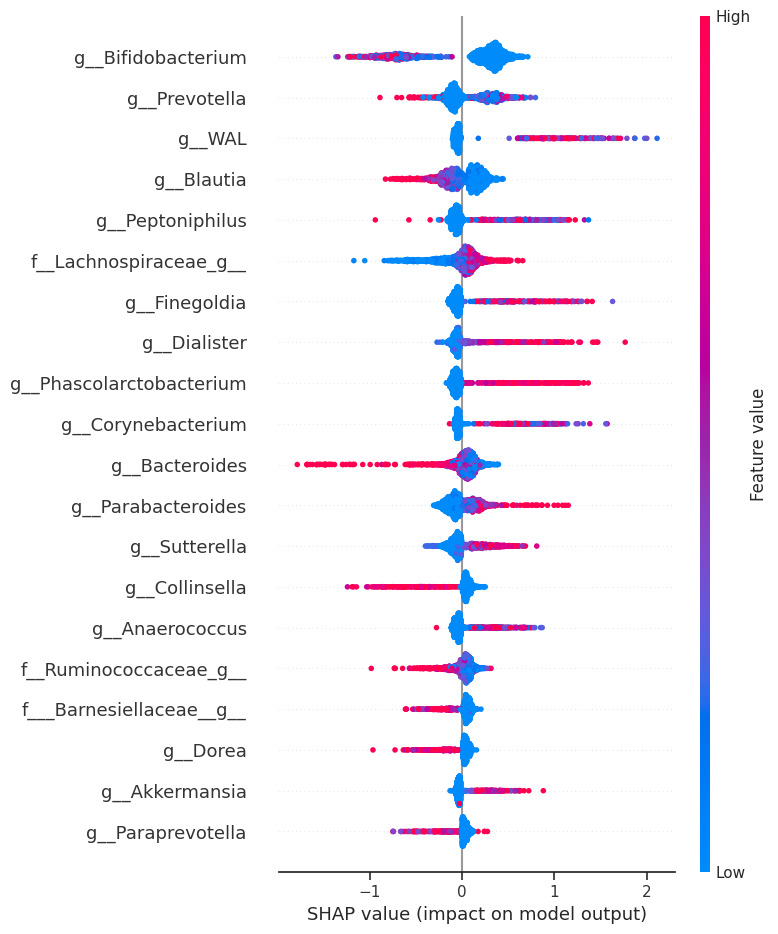

In [46]:
metric.plot_multiclass_roc_cv(dict_cm['y_true'], dict_cm['y_pred_prob'], class_index=1, n_classes=3, class_label='CD')
metric.plot_multiclass_roc_cv(dict_cm['y_true'], dict_cm['y_pred_prob'], class_index=2, n_classes=3, class_label='UC')
metric.plot_multiclass_roc_cv(dict_cm['y_true'], dict_cm['y_pred_prob'], class_index=0, n_classes=3, class_label='nonIBD')
metric.plot_SHAP_multiclass(dict_cm['SHAP_full'],dict_cm['x_true'],class_index=1)
metric.plot_SHAP_multiclass(dict_cm['SHAP_full'],dict_cm['x_true'],class_index=2)
metric.plot_SHAP_multiclass(dict_cm['SHAP_full'],dict_cm['x_true'],class_index=0)
    